In [1]:
import xarray as xr
import pandas as pd
import cftime
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import xesmf as xe
import os

import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler


In [2]:
file_paths = [
'SRSI/era5_pre_AP_2001-2023_mon.nc',  
'SRSI/era5_tmax_AP_2001-2023_mon.nc',
'SRSI/modis_ndvi_AP_2001-2023_mon.nc',
'SRSI/era5_soil-moisture_AP_2001-2023_mon.nc',
'SRSI/era5_tmin_AP_2001-2023_mon.nc',]

datasets = []
names = ['ds_precipitation', 'ds_tmax', 'ds_ndvi', 'ds_soil_moisture', 'ds_tmin']

# Open each NetCDF file and append its Dataset to the list
print("--- NaN Counts for Individual Datasets Before Merging ---")
count = 0
for fp in file_paths:
    count += 1
    ds = xr.open_dataset(fp)

    # Rename variables if necessary, as per your original logic
    if count == 2:
        # Assuming 'pre' is the original variable name in the tmax file
        ds = ds.rename({'pre': 'tmax'})
    if count == 5:
        # Assuming 'pre' is the original variable name in the tmin file
        ds = ds.rename({'pre': 'tmin'})

    print(f"\nDataset from: {fp}")
    print(ds) # Print the dataset structure

    # Corrected: Calculate NaN count for variables IN THE CURRENT 'ds'
    for var_name in ds.data_vars:
        nan_count = ds[var_name].isnull().sum().item()
        total_elements = ds[var_name].size
        nan_percentage = (nan_count / total_elements) * 100 if total_elements > 0 else 0
        print(f"- {var_name}: {nan_count} NaNs ({nan_percentage:.2f}% missing)")

    datasets.append(ds)



--- NaN Counts for Individual Datasets Before Merging ---

Dataset from: SRSI/era5_pre_AP_2001-2023_mon.nc
<xarray.Dataset> Size: 18MB
Dimensions:    (time: 276, longitude: 165, latitude: 101)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-01 ... 2023-12-16T11:00:00
  * longitude  (longitude) float32 660B 23.0 23.25 23.5 ... 63.5 63.75 64.0
  * latitude   (latitude) float32 404B 37.0 36.75 36.5 36.25 ... 12.5 12.25 12.0
Data variables:
    pre        (time, latitude, longitude) float32 18MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Jul 10 14:42:32 2025: cdo selyear,2001/2023 era5_pre_AP...
    CDO:          Climate Data Operators version 2.4.4 (https://mpimet.mpg.de...
- pre: 1301892 NaNs (28.30% missing)

Dataset from: SRSI/era5_tmax_AP_2001-2023_mon.nc
<xarray.Dataset> Size: 18MB
Dimensions:    (time: 276, bnds: 2, longitude: 165, latitude: 101)
Coordinates:
  * time  

In [3]:
combined_dataset = xr.merge(datasets)
print(combined_dataset)

<xarray.Dataset> Size: 947MB
Dimensions:    (time: 552, longitude: 329, latitude: 201, bnds: 2, lon: 164,
                lat: 100)
Coordinates:
  * time       (time) datetime64[ns] 4kB 2001-01-01 ... 2023-12-16T11:00:00
  * longitude  (longitude) float32 1kB 23.0 23.12 23.25 ... 63.75 63.88 64.0
  * latitude   (latitude) float32 804B 12.0 12.12 12.25 ... 36.75 36.88 37.0
  * lon        (lon) float32 656B 23.12 23.38 23.62 23.88 ... 63.38 63.62 63.88
  * lat        (lat) float32 400B 36.88 36.62 36.38 36.12 ... 12.62 12.38 12.12
Dimensions without coordinates: bnds
Data variables:
    pre        (time, latitude, longitude) float32 146MB 1.388e-14 ... 0.3428
    time_bnds  (time, bnds) datetime64[ns] 9kB NaT NaT ... 2023-12-31T23:00:00
    tmax       (time, latitude, longitude) float32 146MB nan nan ... nan 14.59
    ndvi       (time, latitude, longitude) float64 292MB nan nan nan ... nan nan
    swvl1      (time, lat, lon) float64 72MB nan nan nan nan ... nan nan nan nan
    swvl2     

Using existing combined_dataset for visualization.

NaN counts for each variable in the loaded combined_dataset:
- pre: 33205560
- time_bnds: 552
- tmax: 33205560
- ndvi: 33090344
- swvl1: 5699400
- swvl2: 5699400
- swvl3: 5699400
- tmin: 33205560


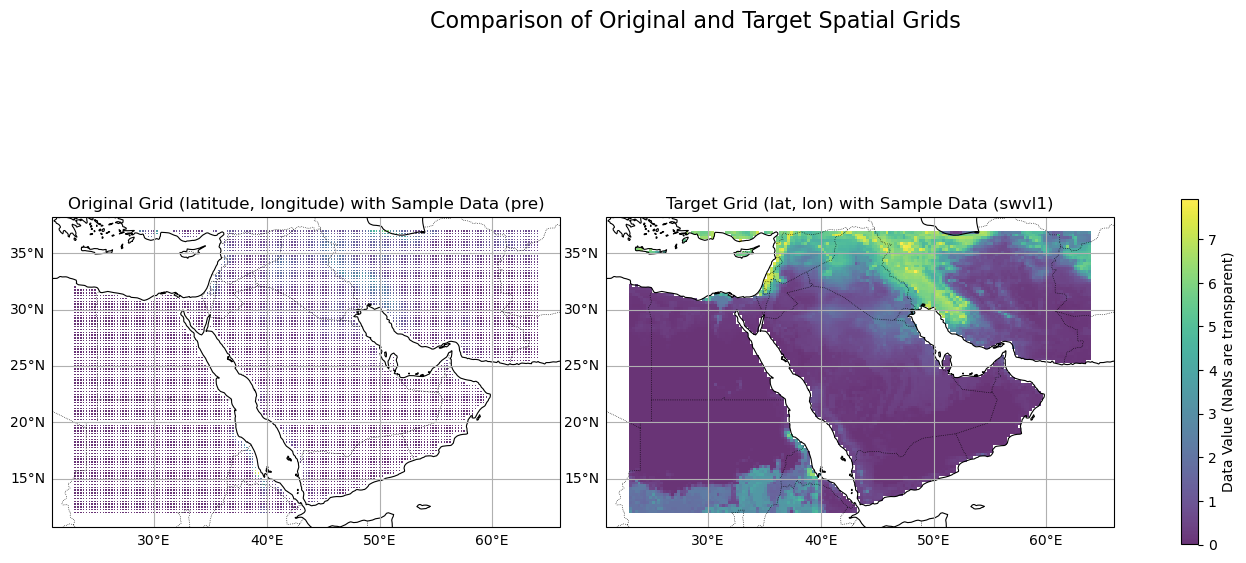

<xarray.Dataset> Size: 947MB
Dimensions:    (time: 552, longitude: 329, latitude: 201, bnds: 2, lon: 164,
                lat: 100)
Coordinates:
  * time       (time) datetime64[ns] 4kB 2001-01-01 ... 2023-12-16T11:00:00
  * longitude  (longitude) float32 1kB 23.0 23.12 23.25 ... 63.75 63.88 64.0
  * latitude   (latitude) float32 804B 12.0 12.12 12.25 ... 36.75 36.88 37.0
  * lon        (lon) float32 656B 23.12 23.38 23.62 23.88 ... 63.38 63.62 63.88
  * lat        (lat) float32 400B 36.88 36.62 36.38 36.12 ... 12.62 12.38 12.12
Dimensions without coordinates: bnds
Data variables:
    pre        (time, latitude, longitude) float32 146MB 1.388e-14 ... 0.3428
    time_bnds  (time, bnds) datetime64[ns] 9kB NaT NaT ... 2023-12-31T23:00:00
    tmax       (time, latitude, longitude) float32 146MB nan nan ... nan 14.59
    ndvi       (time, latitude, longitude) float64 292MB nan nan nan ... nan nan
    swvl1      (time, lat, lon) float64 72MB nan nan nan nan ... nan nan nan nan
    swvl2     

In [4]:
# Inspect your datasetimport xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define dimensions based on your description (these are derived from your dataset's structure)
time_dim = combined_dataset.sizes['time']
lat_orig_dim = combined_dataset.sizes['latitude']
lon_orig_dim = combined_dataset.sizes['longitude']
lat_target_dim = combined_dataset.sizes['lat']
lon_target_dim = combined_dataset.sizes['lon']
bnds_dim = combined_dataset.sizes['bnds'] 

# Define coordinates based on your description (these are now taken directly from the loaded dataset)
time_coords = combined_dataset['time']
longitude_coords = combined_dataset['longitude']
latitude_coords = combined_dataset['latitude']
lon_target_coords = combined_dataset['lon']
lat_target_coords = combined_dataset['lat']
bnds_coords = combined_dataset['bnds'] # Assuming 'bnds' is a coordinate

print("Using existing combined_dataset for visualization.")
# Verify NaN counts in the loaded dataset
print("\nNaN counts for each variable in the loaded combined_dataset:")
for var_name in combined_dataset.data_vars:
    nan_count = combined_dataset[var_name].isnull().sum().item()
    print(f"- {var_name}: {nan_count}")


# --- 1. Extract Grid Coordinates ---
original_lon = combined_dataset['longitude']
original_lat = combined_dataset['latitude']
target_lon = combined_dataset['lon']
target_lat = combined_dataset['lat']

# --- 2. Set up the Plot ---
fig = plt.figure(figsize=(14, 7))
proj = ccrs.PlateCarree() # Standard geographical projection

# Determine a common extent for both plots to ensure comparability
# Max/Min of all latitudes and longitudes
min_lon = min(original_lon.min().item(), target_lon.min().item())
max_lon = max(original_lon.max().item(), target_lon.max().item())
min_lat = min(original_lat.min().item(), target_lat.min().item())
max_lat = max(original_lat.max().item(), target_lat.max().item())

# Add some padding to the extent
lon_pad = (max_lon - min_lon) * 0.05
lat_pad = (max_lat - min_lat) * 0.05
extent = [min_lon - lon_pad, max_lon + lon_pad, min_lat - lat_pad, max_lat + lat_pad]


# --- 3. Plot the Original Grid (latitude, longitude) ---
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
ax1.set_extent(extent, crs=proj)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
gl1 = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl1.top_labels = False
gl1.right_labels = False

# Plot a sample variable from the original grid (e.g., 'pre')
# Use pcolormesh to show grid cells and NaN areas (transparent)
# Take a single time slice for visualization
original_data_slice = combined_dataset['pre'].isel(time=0)
# Ensure coordinates are correctly named for pcolormesh
original_data_slice = original_data_slice.rename({'latitude': 'lat', 'longitude': 'lon'})

# Plot the data. cmap='viridis' is a good default, set vmin/vmax if needed
# Use alpha to make it slightly transparent so gridlines are visible
original_plot = original_data_slice.plot.pcolormesh(
    ax=ax1,
    x='lon', y='lat',
    transform=proj,
    cmap='viridis',
    add_colorbar=False, # Add manually later if needed
    alpha=0.8,
    rasterized=True # Good for dense grids
)
ax1.set_title('Original Grid (latitude, longitude) with Sample Data (pre)')


# --- 4. Plot the Target Grid (lat, lon) ---
ax2 = fig.add_subplot(1, 2, 2, projection=proj)
ax2.set_extent(extent, crs=proj)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
gl2 = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl2.top_labels = False
gl2.right_labels = False

# Plot a sample variable from the target grid (e.g., 'swvl1')
target_data_slice = combined_dataset['swvl1'].isel(time=0)

target_plot = target_data_slice.plot.pcolormesh(
    ax=ax2,
    x='lon', y='lat',
    transform=proj,
    cmap='viridis',
    add_colorbar=False, # Add manually later if needed
    alpha=0.8,
    rasterized=True # Good for dense grids
)
ax2.set_title('Target Grid (lat, lon) with Sample Data (swvl1)')

# --- 5. Final Touches ---
plt.suptitle('Comparison of Original and Target Spatial Grids', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle

# Add a single colorbar for both plots if they share a similar data range
# For this example, we'll add one to the right of the second plot
cbar = fig.colorbar(original_plot, ax=[ax1, ax2], orientation='vertical', shrink=0.6, pad=0.05)
cbar.set_label('Data Value (NaNs are transparent)')

plt.show()

print(combined_dataset)


In [5]:
print("NaN counts for each variable:")
for var_name, data_array in combined_dataset.data_vars.items():
    nan_count = data_array.isnull().sum().item()
    print(f"- {var_name}: {nan_count}")


NaN counts for each variable:
- pre: 33205560
- time_bnds: 552
- tmax: 33205560
- ndvi: 33090344
- swvl1: 5699400
- swvl2: 5699400
- swvl3: 5699400
- tmin: 33205560


# Subsetting for only land to address NaN


--- Defined Common Time Axis (276 steps) ---
First 5: ['2001-01-01T00:00:00.000000000' '2001-02-01T00:00:00.000000000'
 '2001-03-01T00:00:00.000000000' '2001-04-01T00:00:00.000000000'
 '2001-05-01T00:00:00.000000000']
Last 5: ['2023-08-01T00:00:00.000000000' '2023-09-01T00:00:00.000000000'
 '2023-10-01T00:00:00.000000000' '2023-11-01T00:00:00.000000000'
 '2023-12-01T00:00:00.000000000']
--- Defining Target Grid ---
Target Grid:
<xarray.Dataset> Size: 1kB
Dimensions:    (latitude: 101, longitude: 165)
Coordinates:
  * latitude   (latitude) float32 404B 37.0 36.75 36.5 36.25 ... 12.5 12.25 12.0
  * longitude  (longitude) float32 660B 23.0 23.25 23.5 ... 63.5 63.75 64.0
Data variables:
    *empty*

--- Processing Individual Datasets (Renaming, Regridding, Masking) ---

--- Processing Individual Datasets (Renaming, Regridding, Masking, Time Aligning) ---

Processing: SRSI/era5_pre_AP_2001-2023_mon.nc


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


  Performing time alignment for pre...

--- Master Land Mask Created from Regridded & Time-Aligned Precipitation ---

Processing: SRSI/era5_tmax_AP_2001-2023_mon.nc
  Performing time alignment for tmax...

Processing: SRSI/modis_ndvi_AP_2001-2023_mon.nc
  Performing time alignment for ndvi...

Processing: SRSI/era5_soil-moisture_AP_2001-2023_mon.nc
  Performing time alignment for soil_moisture...

Processing: SRSI/era5_tmin_AP_2001-2023_mon.nc
  Performing time alignment for tmin...

--- Merging All Regridded and Masked Datasets ---

--- Refining Land Mask for Final Selection (using all data) ---
Refined Spatial Land Mask shape: (101, 165)
Refined Land Points (number of True values): 11644

--- Applying final dropna to remove purely ocean cells ---

--- Final Dataset After Dropping Pure Ocean Cells ---
<xarray.Dataset> Size: 202MB
Dimensions:        (time: 276, latitude: 101, longitude: 165)
Coordinates:
  * latitude       (latitude) float32 404B 37.0 36.75 36.5 ... 12.5 12.25 12.0
  *

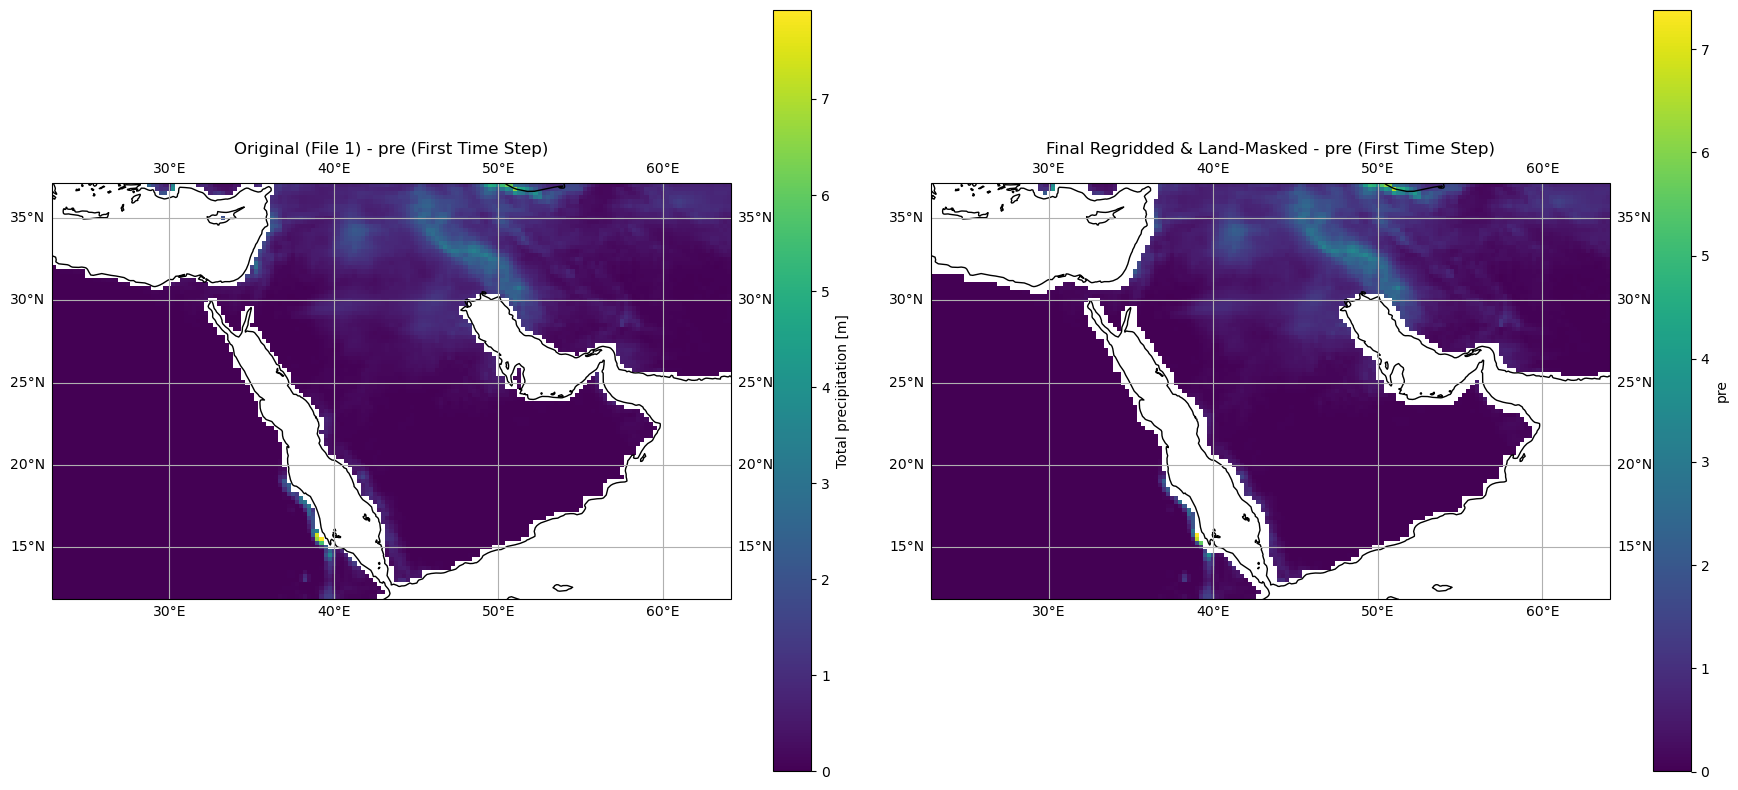

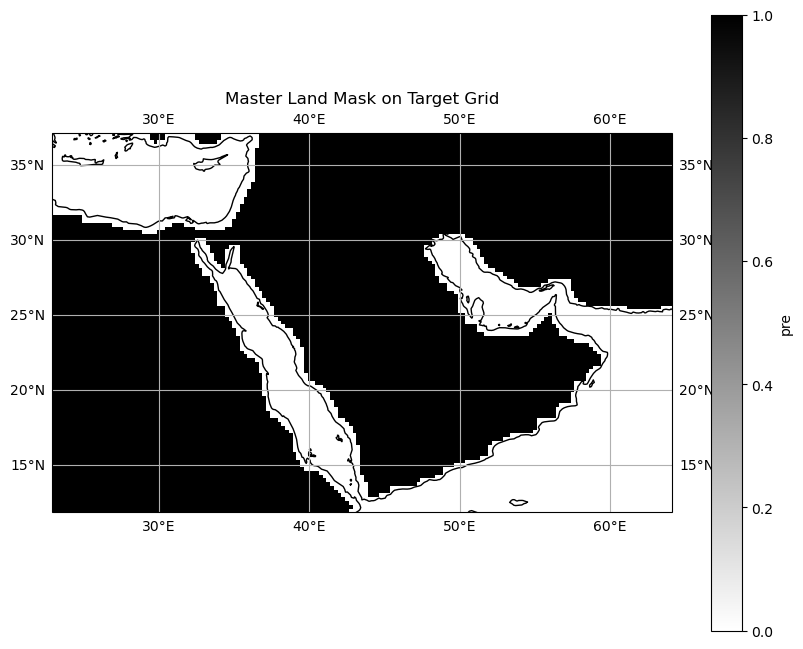

In [6]:
# --- Step 1: Define a Common Target Grid ---
# Let's assume you want to regrid all data to the grid of your ERA5 precipitation file.
# You could also define a custom grid here if preferred.

# Define a common target time axis (ADD THIS)
start_date = '2001-01-01'
end_date = '2023-12-01' # Based on your previous output, most data ends here
                       # If you want to include the last few days of Dec from ERA5,
                       # you could extend this to '2023-12-31' or '2024-01-01' for 'MS' freq.
                       # But for clean monthly starts, 2023-12-01 is consistent.
common_time_axis = pd.date_range(start=start_date, end=end_date, freq='MS') # 'MS' for Month Start
common_time_axis_xr = xr.DataArray(common_time_axis, dims='time', coords={'time': common_time_axis})

print(f"\n--- Defined Common Time Axis ({len(common_time_axis)} steps) ---")
print(f"First 5: {common_time_axis_xr.isel(time=slice(5)).values}")
print(f"Last 5: {common_time_axis_xr.isel(time=slice(-5, None)).values}")

master_land_mask = None # This needs to be set up so it's created once from the first relevant variable.

processed_datasets = []

print("--- Defining Target Grid ---")
target_ds_path = 'SRSI/era5_pre_AP_2001-2023_mon.nc' # Assuming this is your reference grid
ds_target_grid = xr.open_dataset(target_ds_path)

# Ensure target grid has standard lat/lon names
if 'lat' in ds_target_grid.dims and 'latitude' not in ds_target_grid.dims:
    ds_target_grid = ds_target_grid.rename({'lat': 'latitude'})
if 'lon' in ds_target_grid.dims and 'longitude' not in ds_target_grid.dims:
    ds_target_grid = ds_target_grid.rename({'lon': 'longitude'})

# Create a minimal target grid Dataset suitable for xesmf
# xesmf needs 'lat'/'lon' (or 'latitude'/'longitude') coords and optionally their bounds.
# If your target grid already has bounds, great. Otherwise, xesmf can often infer them.
target_grid = xr.Dataset(
    coords={
        'latitude': ds_target_grid['latitude'],
        'longitude': ds_target_grid['longitude'],
    }
)
print("Target Grid:")
print(target_grid)
ds_target_grid.close() # Close the target grid file once we've extracted its coords

# --- Step 2 & 3: Process Each Dataset Individually (Regrid & Mask) ---
print("\n--- Processing Individual Datasets (Renaming, Regridding, Masking) ---")

# --- Step 2 & 3: Process Each Dataset Individually (Regrid & Mask & TIME ALIGN) ---
print("\n--- Processing Individual Datasets (Renaming, Regridding, Masking, Time Aligning) ---")

processed_datasets = [] # Initialize this list here, ensuring it's fresh for the loop
master_land_mask = None # Initialize mask to None, so it's created from the first relevant variable

count = 0
for fp in file_paths:
    count += 1
    print(f"\nProcessing: {fp}")

    ds = xr.open_dataset(fp, chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'})

    # --- Standardize Coordinate Names ---
    if 'lat' in ds.dims and 'latitude' not in ds.dims:
        ds = ds.rename({'lat': 'latitude'})
    if 'lon' in ds.dims and 'longitude' not in ds.dims:
        ds = ds.rename({'lon': 'longitude'})
    if 'x' in ds.dims and 'longitude' not in ds.dims:
        ds = ds.rename({'x': 'longitude'})
    if 'y' in ds.dims and 'latitude' not in ds.dims:
        ds = ds.rename({'y': 'latitude'})

    # --- Rename Data Variables ---
    var_name_in_ds = None
    if count == 1: # Precipitation
        if 'pre' in ds.data_vars: var_name_in_ds = 'pre'
        else: var_name_in_ds = list(ds.data_vars.keys())[0]; ds = ds.rename({var_name_in_ds: 'pre'}); var_name_in_ds = 'pre'
    elif count == 2: # Tmax
        if 'tmax' in ds.data_vars: var_name_in_ds = 'tmax'
        elif 'pre' in ds.data_vars: ds = ds.rename({'pre': 'tmax'}); var_name_in_ds = 'tmax'
        elif 't2m' in ds.data_vars: ds = ds.rename({'t2m': 'tmax'}); var_name_in_ds = 'tmax'
        else: var_name_in_ds = list(ds.data_vars.keys())[0]; ds = ds.rename({var_name_in_ds: 'tmax'}); var_name_in_ds = 'tmax'
    elif count == 3: # NDVI
        if 'ndvi' in ds.data_vars: var_name_in_ds = 'ndvi'
        elif 'Band1' in ds.data_vars: ds = ds.rename({'Band1': 'ndvi'}); var_name_in_ds = 'ndvi'
        else: var_name_in_ds = list(ds.data_vars.keys())[0]; ds = ds.rename({var_name_in_ds: 'ndvi'}); var_name_in_ds = 'ndvi'
    elif count == 4: # Soil Moisture
        if 'swvl1' in ds.data_vars: soil_moisture_vars = [v for v in ds.data_vars if v.startswith('swvl')]; ds = ds.rename({soil_moisture_vars[0]: 'soil_moisture'}) # Rename first swvl to soil_moisture
        elif 'sm' in ds.data_vars: ds = ds.rename({'sm': 'soil_moisture'});
        else: var_name_in_ds = list(ds.data_vars.keys())[0]; ds = ds.rename({var_name_in_ds: 'soil_moisture'});
        var_name_in_ds = 'soil_moisture' # Ensure this is correctly set to 'soil_moisture' for the rest of the flow

    elif count == 5: # Tmin
        if 'tmin' in ds.data_vars: var_name_in_ds = 'tmin'
        elif 'pre' in ds.data_vars: ds = ds.rename({'pre': 'tmin'}); var_name_in_ds = 'tmin'
        elif 'mn2t' in ds.data_vars: ds = ds.rename({'mn2t': 'tmin'}); var_name_in_ds = 'tmin'
        else: var_name_in_ds = list(ds.data_vars.keys())[0]; ds = ds.rename({var_name_in_ds: 'tmin'}); var_name_in_ds = 'tmin'

    # If it's the soil moisture file, it might have multiple layers (swvl1, swvl2, etc.)
    # We want to select *all* relevant soil moisture variables if present, or just the renamed one.
    # The previous logic was slightly problematic for 'soil_moisture' as it only selected the first.
    # Let's adjust to keep all 'swvl' layers if they exist for soil moisture, or just the renamed 'soil_moisture'.
    if 'soil_moisture' in ds.data_vars:
        ds_to_regrid = ds[['soil_moisture'] + [v for v in ds.data_vars if v.startswith('swvl') and v != 'soil_moisture']].copy()
    elif var_name_in_ds: # If a single variable was renamed (pre, tmax, ndvi, tmin)
        ds_to_regrid = ds[[var_name_in_ds]].copy()
    else: # Fallback if renaming logic missed something
        ds_to_regrid = ds.copy()
        print(f"Warning: No specific variable identified for {fp}. Using entire dataset for regridding.")


    # --- Regridding ---
    # Create target_grid if it's not already defined (assuming it is from step 1)
    # This part should be safe if target_grid is globally defined
    if 'target_grid' not in locals() or target_grid is None:
        print("WARNING: target_grid was not defined globally. Defining it now from pre file.")
        target_ds_path = 'SRSI/era5_pre_AP_2001-2023_mon.nc'
        ds_target_grid = xr.open_dataset(target_ds_path)
        if 'lat' in ds_target_grid.dims and 'latitude' not in ds_target_grid.dims:
            ds_target_grid = ds_target_grid.rename({'lat': 'latitude'})
        if 'lon' in ds_target_grid.dims and 'longitude' not in ds_target_grid.dims:
            ds_target_grid = ds_target_grid.rename({'lon': 'longitude'})
        target_grid = xr.Dataset(coords={'latitude': ds_target_grid['latitude'], 'longitude': ds_target_grid['longitude']})
        ds_target_grid.close()

    # Reuse weights if they exist
    weights_filename = f'weights_regridder_{var_name_in_ds}_to_target.nc'
    if os.path.exists(weights_filename):
        regridder = xe.Regridder(ds_to_regrid, target_grid, method='bilinear', reuse_weights=True, filename=weights_filename)
    else:
        regridder = xe.Regridder(ds_to_regrid, target_grid, method='bilinear', reuse_weights=False, filename=weights_filename)

    ds_regridded = regridder(ds_to_regrid)

    # --- Time Alignment Step (NEW AND CRUCIAL) ---
    print(f"  Performing time alignment for {var_name_in_ds}...")
    # Use 'interp' with 'linear' method to align to common_time_axis.
    # This will interpolate mid-month values (tmax, tmin) to the start of the month,
    # and reindex others (pre, ndvi, soil_moisture) to match the exact `common_time_axis`.
    # Using kwargs={"fill_value": "extrapolate"} is generally for extending data, which we don't want here.
    # If a time point in common_time_axis is outside the range of ds_regridded, it will become NaN.
    ds_time_aligned = ds_regridded.interp(time=common_time_axis_xr['time'], method='linear')


    # --- Apply Land Mask on Time-Aligned Data ---
    # Create master_land_mask ONLY ONCE from the first relevant variable (e.g., 'pre')
    if master_land_mask is None:
        mask_source_var_name = 'pre' # Use precipitation as the base for the land mask
        if mask_source_var_name in ds_time_aligned.data_vars:
            master_land_mask = ds_time_aligned[mask_source_var_name].isel(time=0).notnull().compute()
            print("\n--- Master Land Mask Created from Regridded & Time-Aligned Precipitation ---")
        else:
            # Fallback if 'pre' is not the first variable loaded or named
            first_regridded_var = list(ds_time_aligned.data_vars.keys())[0]
            master_land_mask = ds_time_aligned[first_regridded_var].isel(time=0).notnull().compute()
            print(f"--- Master Land Mask Created from Regridded & Time-Aligned {first_regridded_var} ---")

    # Apply the mask: wherever master_land_mask is False (ocean), set data to NaN
    ds_masked_nan = ds_time_aligned.where(master_land_mask)
    processed_datasets.append(ds_masked_nan)

# After this loop, proceed with xr.merge(processed_datasets, compat='no_conflicts')
# and the rest of your script.
# --- Step 4: Merge the Regridded and Masked Datasets ---
print("\n--- Merging All Regridded and Masked Datasets ---")
# All datasets in processed_datasets should now be on the same grid and have NaNs for oceans.
try:
    combined_dataset_regridded = xr.merge(processed_datasets, compat='no_conflicts')
except Exception as e:
    print(f"Error merging regridded datasets: {e}")
    print("This indicates a problem with coordinate alignment even after regridding. "
          "Double-check that all datasets truly share identical 'latitude' and 'longitude' coordinates after regridding.")
    raise


# --- Additional check: If dropna seems ineffective ---
# This section creates `all_data_points_mask`
print("\n--- Refining Land Mask for Final Selection (using all data) ---")
# Create a boolean mask where a point is True if it's not NaN for ANY variable, across ALL time
# Initialize with a mask of all False (no land)
# Ensure to select a variable that definitely exists and has lat/lon dims
if 'pre' in combined_dataset_regridded.data_vars:
    initial_var_for_mask_base = 'pre'
else:
    initial_var_for_mask_base = list(combined_dataset_regridded.data_vars.keys())[0]

# Ensure the selected variable has time dimension; if not, pick another one
if 'time' not in combined_dataset_regridded[initial_var_for_mask_base].dims:
    print(f"Warning: Selected mask base variable '{initial_var_for_mask_base}' does not have a time dimension. Trying another variable.")
    for var_name_check in combined_dataset_regridded.data_vars:
        if 'time' in combined_dataset_regridded[var_name_check].dims:
            initial_var_for_mask_base = var_name_check
            break
    else:
        raise ValueError("Could not find any variable with a 'time' dimension to create all_data_points_mask.")


# Initialize the mask with False values, matching the spatial dimensions of the initial variable
all_data_points_mask = xr.full_like(
    combined_dataset_regridded[initial_var_for_mask_base].isel(time=0),
    False,
    dtype=bool
)

for var_name in combined_dataset_regridded.data_vars:
    # Skip if variable doesn't have spatial and time dims as expected
    if 'latitude' not in combined_dataset_regridded[var_name].dims or \
       'longitude' not in combined_dataset_regridded[var_name].dims or \
       'time' not in combined_dataset_regridded[var_name].dims:
        continue # Skip variables that aren't spatiotemporal

    # Compute notnull for each variable, then combine with OR
    # .any(dim='time') checks if the point is ever notnull over time
    all_data_points_mask = all_data_points_mask | combined_dataset_regridded[var_name].notnull().any(dim='time')

# Ensure the mask is computed
all_data_points_mask = all_data_points_mask.compute() # This computes the mask itself

print(f"Refined Spatial Land Mask shape: {all_data_points_mask.shape}")
print(f"Refined Land Points (number of True values): {all_data_points_mask.sum().item()}")

# --- Applying final dropna to remove purely ocean cells ---
print("\n--- Applying final dropna to remove purely ocean cells ---")

# Step 1: Drop along latitude dimension
temp_dataset = combined_dataset_regridded.dropna(dim='latitude', how='all')

# Step 2: Drop along longitude dimension on the result from Step 1
final_land_dataset = temp_dataset.dropna(dim='longitude', how='all')

print("\n--- Final Dataset After Dropping Pure Ocean Cells ---")
print(final_land_dataset)

# ... (further down, in the "Refined Land Mask" section) ...

# Apply this refined mask for selection
# This will keep the full latitude/longitude dimensions, but fill ocean with NaNs
combined_dataset_strict_land = combined_dataset_regridded.where(all_data_points_mask)
print("\n--- Combined Dataset after STRICT Land Masking (retaining full dims) ---")
print(combined_dataset_strict_land)


# Now, try the dropna again on this strictly masked dataset
# This is useful if the original `master_land_mask` wasn't capturing all land precisely.
# If `all_data_points_mask` is truly robust, this `dropna` should now work better.
print("\n--- Applying final dropna to STRICTLY masked data ---")
temp_dataset_strict = combined_dataset_strict_land.dropna(dim='latitude', how='all')
final_land_dataset_strict = temp_dataset_strict.dropna(dim='longitude', how='all')
print("\n--- Final Dataset After STRICT Land Masking AND dropna ---")
print(final_land_dataset_strict)
# --- Verify NaN counts and shapes ---
print("\n--- NaN Counts for Final Dataset ---")
for var_name in final_land_dataset.data_vars:
    # Use .compute() to force evaluation for accurate NaN count
    nan_count = final_land_dataset[var_name].isnull().sum().compute().item()
    total_elements = final_land_dataset[var_name].size
    nan_percentage = (nan_count / total_elements) * 100 if total_elements > 0 else 0
    print(f"- {var_name}: {nan_count} NaNs ({nan_percentage:.2f}% missing)")

print(f"Final 'latitude' dimension size: {final_land_dataset['latitude'].size}")
print(f"Final 'longitude' dimension size: {final_land_dataset['longitude'].size}")

# Example of plotting to visualize the effect (requires cartopy)
try:
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot an original dataset variable (e.g., from the first file before any processing)
    # Re-open the first file briefly for comparison
    ds_orig_pre = xr.open_dataset(file_paths[0], chunks={}) # No chunks for quick plot
    if 'pre' in ds_orig_pre.data_vars:
        ds_orig_pre['pre'].isel(time=0).plot(ax=axes[0], cmap='viridis', add_colorbar=True,
                                             transform=ccrs.PlateCarree())
        axes[0].set_title(f'Original (File 1) - pre (First Time Step)')
    else: # Fallback if 'pre' not found
        list(ds_orig_pre.data_vars.values())[0].isel(time=0).plot(ax=axes[0], cmap='viridis', add_colorbar=True,
                                                                 transform=ccrs.PlateCarree())
        axes[0].set_title(f'Original (File 1) - {list(ds_orig_pre.data_vars.keys())[0]} (First Time Step)')
    axes[0].coastlines()
    axes[0].gridlines(draw_labels=True)
    ds_orig_pre.close() # Close to free memory

    # Plot the final regridded and masked dataset variable
    # Pick one variable from the final dataset for plotting
    plot_var_name = list(final_land_dataset.data_vars.keys())[0]
    final_land_dataset[plot_var_name].isel(time=0).plot(ax=axes[1], cmap='viridis', add_colorbar=True,
                                                       transform=ccrs.PlateCarree())
    axes[1].set_title(f'Final Regridded & Land-Masked - {plot_var_name} (First Time Step)')
    axes[1].coastlines()
    axes[1].gridlines(draw_labels=True)

    plt.tight_layout()
    plt.show()

    # Plot the master land mask
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    master_land_mask.plot(ax=ax, cmap='binary', add_colorbar=True, transform=ccrs.PlateCarree())
    ax.set_title('Master Land Mask on Target Grid')
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    plt.show()

except ImportError:
    print("\nCartopy not installed. Skipping geographical plotting for visualization.")
    print("Install it using: pip install cartopy")


# Regridding data to fit on two spatial dimensions

In [7]:

# --- 1. Define Your Target Grid ---
# We will use the 'lat' and 'lon' coordinates from your swvl variables as the target grid.
# This means variables on (latitude, longitude) will be regridded to (lat, lon).

ds_target_grid = xr.Dataset(
    coords={
        'lat': combined_dataset['lat'],
        'lon': combined_dataset['lon']
    }
)
print("Target Grid (based on swvl dimensions):")
print(ds_target_grid)

# --- 2. Isolate Variables by their Source Grid ---

# Variables currently on (time, latitude, longitude) grid:
vars_to_regrid = ['pre', 'tmax', 'tmin', 'ndvi']
# Rename 'latitude' to 'lat' and 'longitude' to 'lon' for xesmf compatibility
ds_to_regrid = combined_dataset[vars_to_regrid].rename({'latitude': 'lat', 'longitude': 'lon'})

# Variables already on (time, lat, lon) grid:
vars_already_on_target_grid = ['swvl1', 'swvl2', 'swvl3']
ds_already_on_target_grid = combined_dataset[vars_already_on_target_grid]

# Handle time_bnds and bnds: time_bnds is already on (time, bnds), which is not a spatial grid.
# We'll include it in the final merge without regridding its spatial dimensions (as it has none).
time_bnds_data = combined_dataset['time_bnds']

# --- 3. Perform Regridding for Variables Not on the Target Grid ---

# Create a regridder object. This step can take some time the first time it's run
# as it computes weights for interpolation.
# We need to ensure the source dataset/DataArray used for creating the regridder
# has the correct dimension names ('lat', 'lon') for xesmf.
# So, we pass a DataArray that has these dimensions.
# It's crucial that the *coordinate names* passed to xe.Regridder match 'lat'/'lon'
# even if the original dimensions were 'latitude'/'longitude'.
regridder = xe.Regridder(
    ds_to_regrid.isel(time=0, drop=True), # Use a single time slice to define the source grid
    ds_target_grid,
    method='bilinear', # Choose an appropriate method: 'bilinear', 'conservative', 'nearest_s2d', etc.
    reuse_weights=False, # Saves and reuses weights for faster subsequent runs
    filename='regrid_weights.nc' # Specify a filename to save/load weights
)
print("\nRegridder created.")

# Apply the regridder to each variable that needs regridding
regridded_vars = {}
for var_name in vars_to_regrid:
    print(f"Regridding {var_name}...")
    # XESMF expects 'lat' and 'lon' as coordinate names, not 'latitude'/'longitude'.
    # We rename the coordinate *variables* for the source before regridding.
    source_var = combined_dataset[var_name].rename({'latitude': 'lat', 'longitude': 'lon'})
    regridded_vars[var_name] = regridder(source_var)
    print(f"Regridding {var_name} complete. New dims: {regridded_vars[var_name].dims}")

# --- 4. Assemble the New, Consistently Gridded Dataset ---

# Start with variables that were already on the target grid
final_dataset = ds_already_on_target_grid.copy()

# Add the regridded variables
for var_name, data_array in regridded_vars.items():
    final_dataset[var_name] = data_array

# Add time_bnds back (it doesn't have spatial dimensions, so no regridding needed)
# Ensure we are explicitly selecting the time_bnds variable from the original dataset
final_dataset['time_bnds'] = combined_dataset['time_bnds']

# Ensure primary coordinates are consistent and correctly named
final_dataset = final_dataset.set_coords(['time', 'lat', 'lon'])

print("\nFinal Dataset with Consistent Spatial Dimensions:")
print(final_dataset)

# --- 5. Verify NaN Counts in the New Dataset (Optional but Recommended) ---
print("\nNaN counts for each variable in the REGRIDDED dataset:")
for var_name, data_array in final_dataset.data_vars.items():
    nan_count = data_array.isnull().sum().item()
    print(f"- {var_name}: {nan_count}")


Target Grid (based on swvl dimensions):
<xarray.Dataset> Size: 1kB
Dimensions:  (lat: 100, lon: 164)
Coordinates:
  * lat      (lat) float32 400B 36.88 36.62 36.38 36.12 ... 12.62 12.38 12.12
  * lon      (lon) float32 656B 23.12 23.38 23.62 23.88 ... 63.38 63.62 63.88
Data variables:
    *empty*

Regridder created.
Regridding pre...
Regridding pre complete. New dims: ('time', 'lat', 'lon')
Regridding tmax...
Regridding tmax complete. New dims: ('time', 'lat', 'lon')
Regridding tmin...
Regridding tmin complete. New dims: ('time', 'lat', 'lon')
Regridding ndvi...
Regridding ndvi complete. New dims: ('time', 'lat', 'lon')

Final Dataset with Consistent Spatial Dimensions:
<xarray.Dataset> Size: 398MB
Dimensions:    (time: 552, lat: 100, lon: 164, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 4kB 2001-01-01 ... 2023-12-16T11:00:00
  * lon        (lon) float32 656B 23.12 23.38 23.62 23.88 ... 63.38 63.62 63.88
  * lat        (lat) float32 400B 36.88 36.62 36.38 36.12 ... 12.62


--- NaN Counts for Combined Dataset BEFORE final dropna ---
- pre: 1385796 NaNs (30.13% missing)
- tmax: 1397440 NaNs (30.38% missing)
- ndvi: 1388917 NaNs (30.20% missing)
- soil_moisture: 1385796 NaNs (30.13% missing)
- swvl2: 1385796 NaNs (30.13% missing)
- swvl3: 1385796 NaNs (30.13% missing)
- tmin: 1397440 NaNs (30.38% missing)

--- Applying final dropna to remove purely ocean cells ---

--- Final Dataset After Dropping Pure Ocean Cells ---
<xarray.Dataset> Size: 202MB
Dimensions:        (time: 276, latitude: 101, longitude: 165)
Coordinates:
  * latitude       (latitude) float32 404B 37.0 36.75 36.5 ... 12.5 12.25 12.0
  * longitude      (longitude) float32 660B 23.0 23.25 23.5 ... 63.5 63.75 64.0
  * time           (time) datetime64[ns] 2kB 2001-01-01 ... 2023-12-01
Data variables:
    pre            (time, latitude, longitude) float32 18MB dask.array<chunksize=(276, 101, 165), meta=np.ndarray>
    tmax           (time, latitude, longitude) float32 18MB dask.array<chunksize=(2

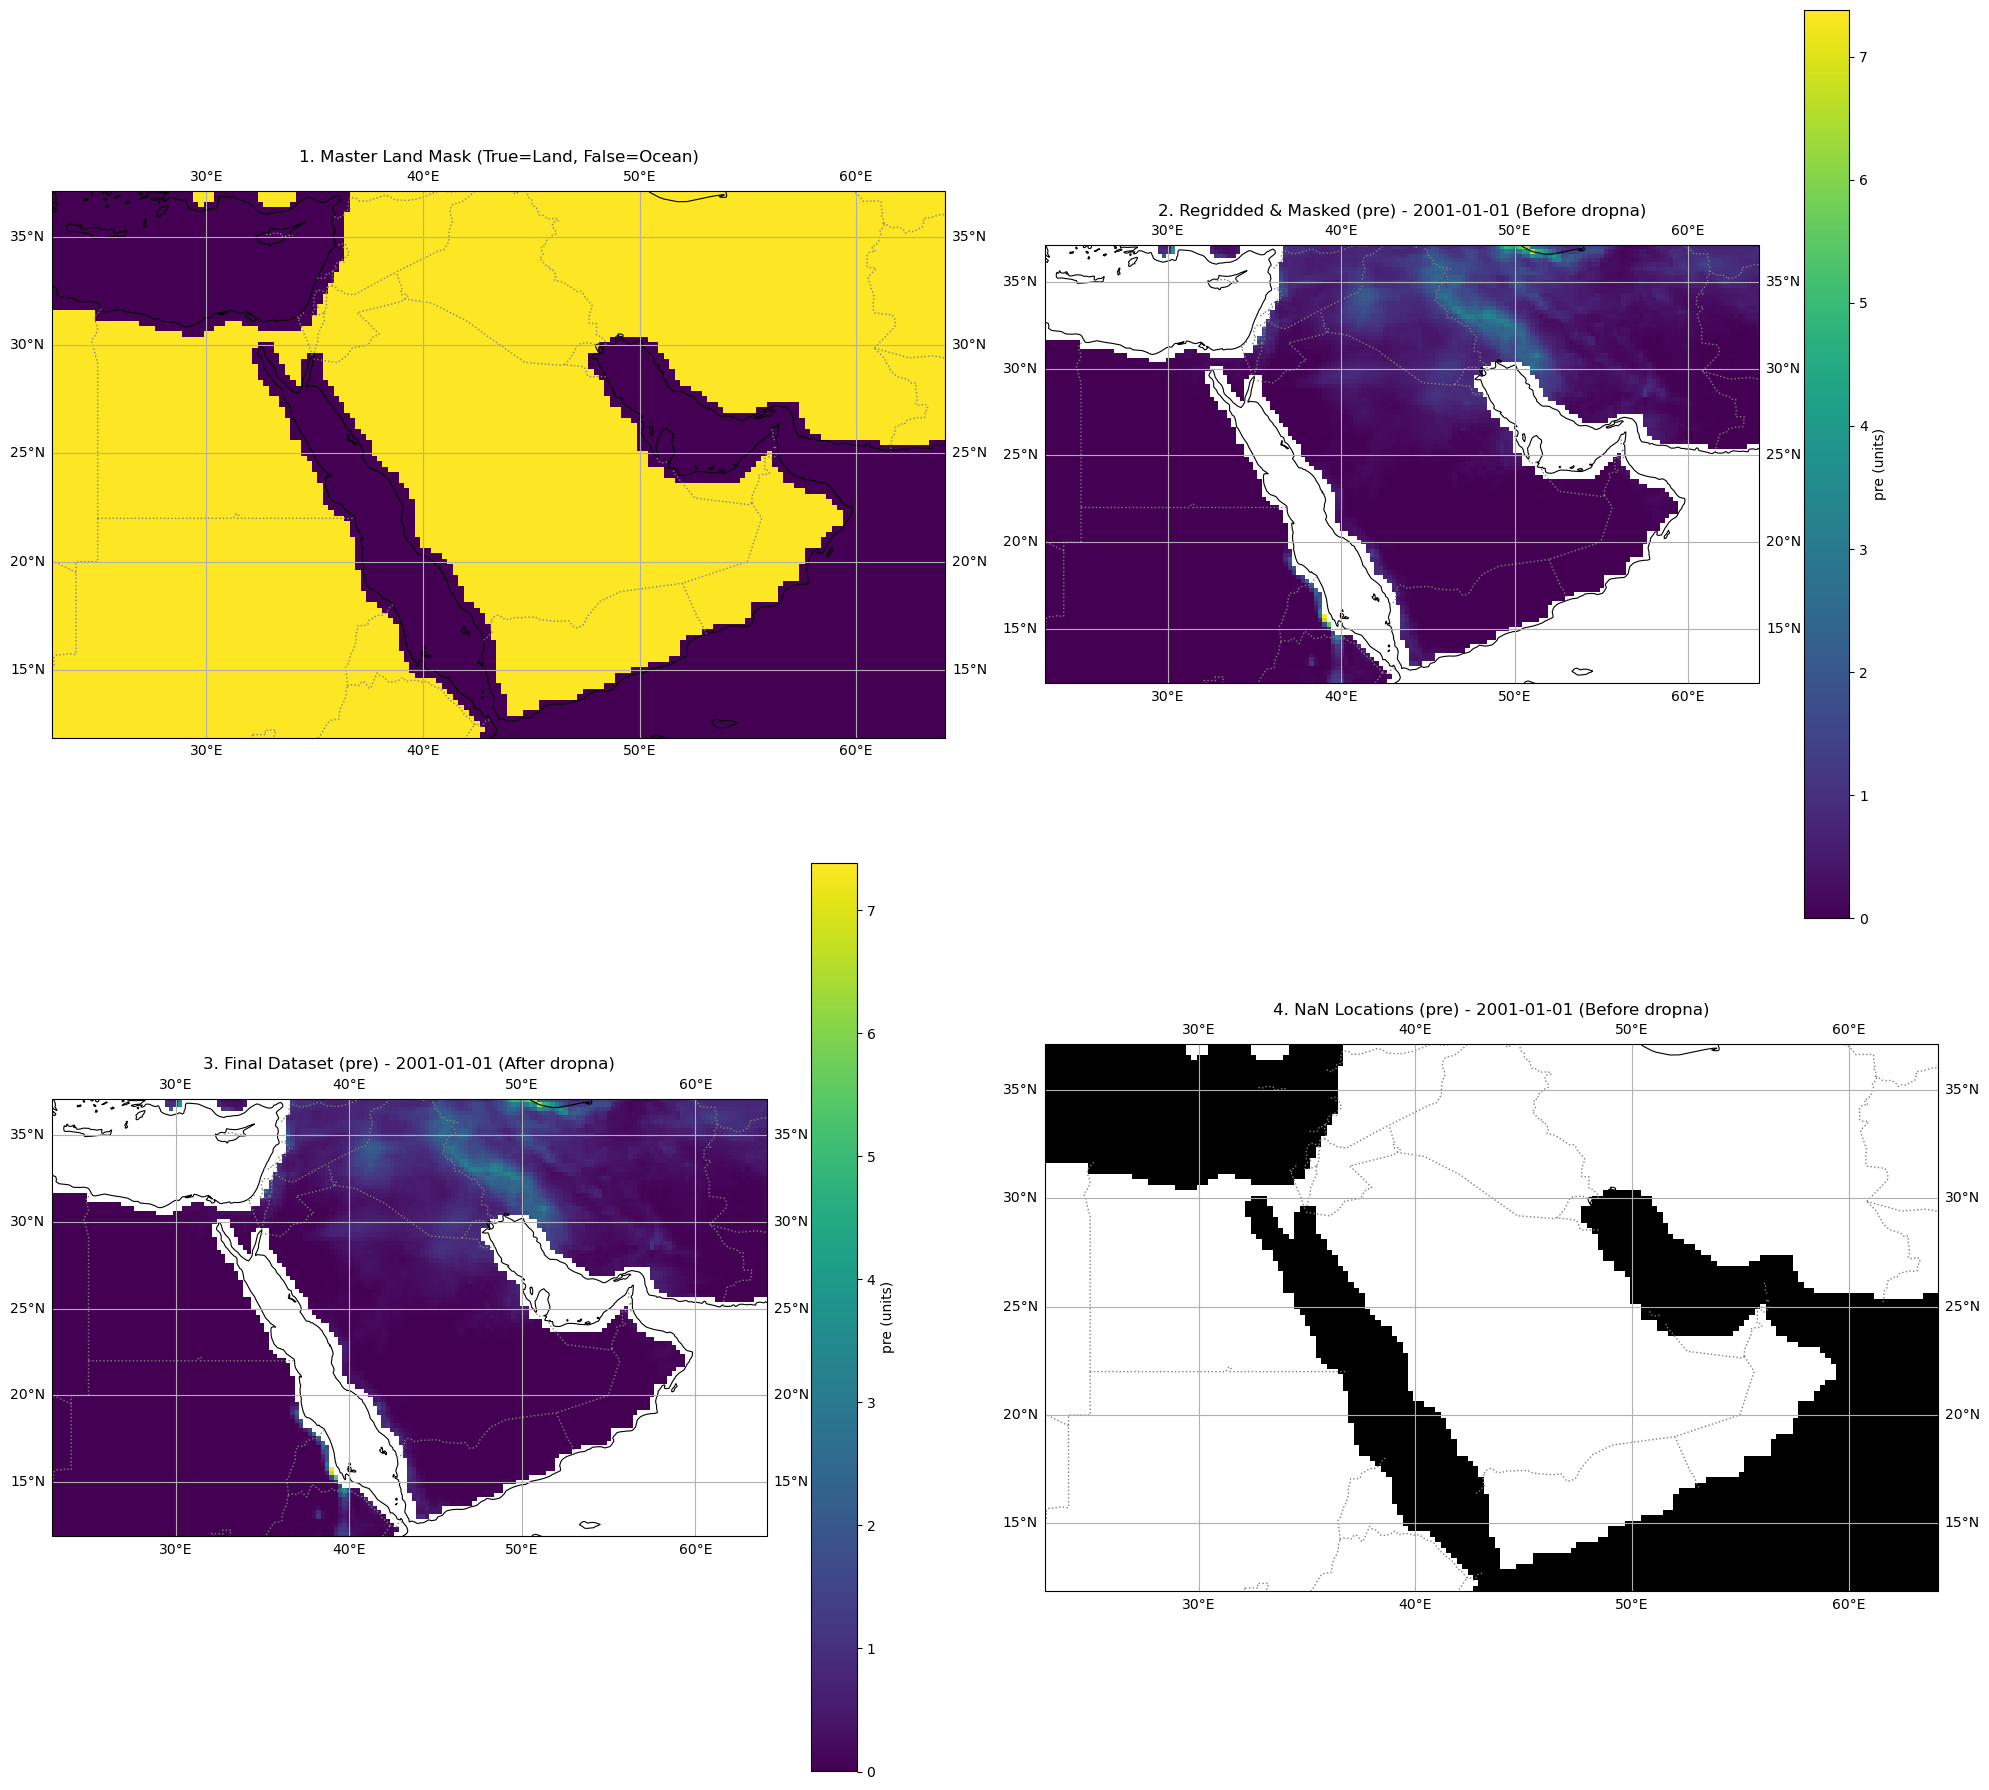

In [8]:
# --- Visualizing NaN counts before the final dropna ---
print("\n--- NaN Counts for Combined Dataset BEFORE final dropna ---")
for var_name in combined_dataset_regridded.data_vars:
    nan_count = combined_dataset_regridded[var_name].isnull().sum().compute().item()
    total_elements = combined_dataset_regridded[var_name].size
    nan_percentage = (nan_count / total_elements) * 100 if total_elements > 0 else 0
    print(f"- {var_name}: {nan_count} NaNs ({nan_percentage:.2f}% missing)")

# --- Final Dropna to remove purely ocean rows/columns ---
print("\n--- Applying final dropna to remove purely ocean cells ---")
# The problem might be here. Let's see the effect visually.
temp_dataset = combined_dataset_regridded.dropna(dim='latitude', how='all')
final_land_dataset = temp_dataset.dropna(dim='longitude', how='all')

print("\n--- Final Dataset After Dropping Pure Ocean Cells ---")
print(final_land_dataset)

# --- Verify NaN counts for the final dataset ---
print("\n--- NaN Counts for Final Dataset AFTER final dropna ---")
for var_name in final_land_dataset.data_vars:
    nan_count = combined_dataset_regridded[var_name].isnull().sum().compute().item()
    total_elements = final_land_dataset[var_name].size
    nan_percentage = (nan_count / total_elements) * 100 if total_elements > 0 else 0
    print(f"- {var_name}: {nan_count} NaNs ({nan_percentage:.2f}% missing)")

print(f"Final 'latitude' dimension size: {final_land_dataset['latitude'].size}")
print(f"Final 'longitude' dimension size: {final_land_dataset['longitude'].size}")

print("\n--- Final Step: Creating a Land-Only, Stacked Dataset ---")

# Step 1: Apply the refined land mask to the combined dataset
# This sets all non-land (ocean or permanently NaN land) points to NaN.
# 'all_data_points_mask' needs to be defined BEFORE this step.
# Make sure the 'all_data_points_mask' creation logic is placed higher up in your script
# (as we discussed in the previous fix for NameError: 'all_data_points_mask' is not defined).
combined_dataset_strict_land = combined_dataset_regridded.where(all_data_points_mask)

print("\n--- Combined Dataset after STRICT Land Masking (still rectangular grid, but only data on land) ---")
print(combined_dataset_strict_land)


# Step 2: Stack the spatial dimensions into a single 'location' dimension
# This effectively creates a 1D array of land points, removing all explicit NaN locations.
# It's crucial to select the variables you want to stack.
# We'll stack 'latitude' and 'longitude' into a new dimension called 'location'.

# Exclude coordinates/variables that you don't want to be part of the stacking or might cause issues.
# 'time_bnds' is often not a spatial variable and might not align.
variables_to_stack = [v for v in combined_dataset_strict_land.data_vars if v not in ['time_bnds']]

# Create a new dataset with only the variables we want to stack.
# We also want to ensure that if 'time_bnds' exists, it's not part of the stacked variables,
# but it should still be a coordinate if it's consistently present.
# For simplicity, we'll stack just the data variables.
ds_to_stack = combined_dataset_strict_land[variables_to_stack]

# Perform the stacking
# This creates a MultiIndex for 'location' (latitude, longitude)
final_land_dataset_stacked = ds_to_stack.stack(location=('latitude', 'longitude'))

print("\n--- Final Land-Only Dataset (Stacked - before final dropna on location) ---")
print(final_land_dataset_stacked)


# Step 3: Drop rows from the 'location' dimension where all variables are NaN across all time steps.
# This is the equivalent of the `dropna(how='all')` but now on the single stacked dimension.
# This will remove any 'location' (lat, lon) pairs that are truly all NaN for the selected variables.
final_land_dataset_stacked = final_land_dataset_stacked.dropna(dim='location', how='all')

print("\n--- Final Land-Only Dataset (Stacked and Finalized) ---")
print(final_land_dataset_stacked)

# Verify final NaN counts (should be minimal, only internal data gaps)
print("\n--- NaN Counts for Final STACKED Dataset ---")
for var_name in final_land_dataset_stacked.data_vars:
    nan_count = final_land_dataset_stacked[var_name].isnull().sum().compute().item()
    total_elements = final_land_dataset_stacked[var_name].size
    nan_percentage = (nan_count / total_elements) * 100 if total_elements > 0 else 0
    print(f"- {var_name}: {nan_count} NaNs ({nan_percentage:.2f}% missing)")

print(f"Final 'location' dimension size: {final_land_dataset_stacked['location'].size}")

# --- You will now primarily use 'final_land_dataset_stacked' for your analysis ---
# If you need to revert to a 2D grid for specific plotting or operations, you can unstack:
# final_land_dataset_unstacked = final_land_dataset_stacked.unstack('location')
# Be aware that unstacking will re-introduce NaNs for all the ocean points that were removed.

# --- Additional check: If dropna seems ineffective ---
# This section creates `all_data_points_mask`
print("\n--- Refining Land Mask for Final Selection (using all data) ---")
# Create a boolean mask where a point is True if it's not NaN for ANY variable, across ALL time
# Initialize with a mask of all False (no land)
# Ensure to select a variable that definitely exists and has lat/lon dims
if 'pre' in combined_dataset_regridded.data_vars:
    initial_var_for_mask_base = 'pre'
else:
    initial_var_for_mask_base = list(combined_dataset_regridded.data_vars.keys())[0]

all_data_points_mask = xr.full_like(
    combined_dataset_regridded[initial_var_for_mask_base].isel(time=0),
    False,
    dtype=bool
)

for var_name in combined_dataset_regridded.data_vars:
    # Compute notnull for each variable, then combine with OR
    # .any(dim='time') checks if the point is ever notnull over time
    all_data_points_mask = all_data_points_mask | combined_dataset_regridded[var_name].notnull().any(dim='time')

# Ensure the mask is computed
all_data_points_mask = all_data_points_mask.compute() # This computes the mask itself

print(f"Refined Spatial Land Mask shape: {all_data_points_mask.shape}")
print(f"Refined Land Points: {all_data_points_mask.sum().item()}")

### --- Visualization of NaNs ---
print("\n--- Generating Spatial NaN Visualizations ---")

# Choose a variable for plotting (e.g., 'pre')
plot_var = 'pre'
if plot_var not in combined_dataset_regridded.data_vars:
    plot_var = list(combined_dataset_regridded.data_vars.keys())[0]
    print(f"Plotting variable changed to: {plot_var}")

# Get a time slice for plotting
time_slice_index = 0
time_val = combined_dataset_regridded['time'].isel(time=time_slice_index).dt.strftime("%Y-%m-%d").item()

fig, axes = plt.subplots(2, 2, figsize=(20, 18), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten() # Flatten the 2x2 array of axes for easier indexing

# Plot 1: Master Land Mask (True=Land, False=Ocean)
ax0 = axes[0]
master_land_mask.plot(ax=ax0, cmap='viridis', add_colorbar=False, transform=ccrs.PlateCarree())
ax0.set_title('1. Master Land Mask (True=Land, False=Ocean)')
ax0.coastlines(resolution='50m', color='black', linewidth=0.8)
ax0.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax0.gridlines(draw_labels=True)

# Plot 2: Regridded + Masked Data (BEFORE final dropna)
ax1 = axes[1]
# Use .plot.imshow() for better handling of NaNs as transparent.
# Set vmin/vmax if you want consistent color scale.
combined_dataset_regridded[plot_var].isel(time=time_slice_index).plot.imshow(
    ax=ax1, cmap='viridis', add_colorbar=True, transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': f'{plot_var} (units)'}
)
ax1.set_title(f'2. Regridded & Masked ({plot_var}) - {time_val} (Before dropna)')
ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax1.gridlines(draw_labels=True)


# Plot 3: Regridded + Masked Data (AFTER final dropna)
ax2 = axes[2]
# This plot should show a tighter bounding box if dropna worked as expected
# Using .imshow again to handle NaNs if any remain (though ideally they shouldn't in the cropped area)
if 'latitude' in final_land_dataset.dims and 'longitude' in final_land_dataset.dims and \
   final_land_dataset['latitude'].size > 0 and final_land_dataset['longitude'].size > 0:
    final_land_dataset[plot_var].isel(time=time_slice_index).plot.imshow(
        ax=ax2, cmap='viridis', add_colorbar=True, transform=ccrs.PlateCarree(),
        cbar_kwargs={'label': f'{plot_var} (units)'}
    )
    ax2.set_title(f'3. Final Dataset ({plot_var}) - {time_val} (After dropna)')
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    ax2.gridlines(draw_labels=True)
else:
    ax2.set_title(f'3. Final Dataset ({plot_var}) - {time_val} (After dropna - No Data)')
    ax2.text(0.5, 0.5, 'No spatial data remaining after dropna',
             horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


# Plot 4: NaNs in the combined_dataset_regridded (before dropna)
# This will show 'True' where NaNs are present, 'False' where data exists
ax3 = axes[3]
combined_dataset_regridded[plot_var].isnull().isel(time=time_slice_index).plot.imshow(
    ax=ax3, cmap='binary', add_colorbar=False, transform=ccrs.PlateCarree(),
    vmin=0, vmax=1 # Force 0/1 for False/True
)
ax3.set_title(f'4. NaN Locations ({plot_var}) - {time_val} (Before dropna)')
ax3.coastlines(resolution='50m', color='black', linewidth=0.8)
ax3.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
ax3.gridlines(draw_labels=True)


plt.tight_layout()
plt.show()


In [9]:
print(combined_dataset_regridded)

<xarray.Dataset> Size: 202MB
Dimensions:        (time: 276, latitude: 101, longitude: 165)
Coordinates:
  * latitude       (latitude) float32 404B 37.0 36.75 36.5 ... 12.5 12.25 12.0
  * longitude      (longitude) float32 660B 23.0 23.25 23.5 ... 63.5 63.75 64.0
  * time           (time) datetime64[ns] 2kB 2001-01-01 ... 2023-12-01
Data variables:
    pre            (time, latitude, longitude) float32 18MB dask.array<chunksize=(276, 101, 165), meta=np.ndarray>
    tmax           (time, latitude, longitude) float32 18MB dask.array<chunksize=(276, 101, 165), meta=np.ndarray>
    ndvi           (time, latitude, longitude) float64 37MB dask.array<chunksize=(276, 101, 165), meta=np.ndarray>
    soil_moisture  (time, latitude, longitude) float64 37MB dask.array<chunksize=(276, 101, 165), meta=np.ndarray>
    swvl2          (time, latitude, longitude) float64 37MB dask.array<chunksize=(276, 101, 165), meta=np.ndarray>
    swvl3          (time, latitude, longitude) float64 37MB dask.array<chun

# Train/test split

In [10]:
print("\n--- Preparing Data for ConvLSTM ---")

# 1. Unstack 'location' back to (latitude, longitude)
# This will re-introduce NaN values for ocean areas.
final_land_dataset_unstacked = final_land_dataset_stacked.unstack('location')
print("\nDataset after unstacking 'location':")
print(final_land_dataset_unstacked)

# 2. Fill NaNs (e.g., for ocean areas and any remaining data gaps)
# Common strategy for ConvLSTM: fill ocean with 0, or a representative value.
# For other NaNs (e.g., cloud cover in NDVI), you might choose a different imputation.
# For simplicity, we'll fill all NaNs with 0 for now.
final_land_dataset_filled = final_land_dataset_unstacked.fillna(0)
print("\nDataset after filling NaNs with 0:")
print(final_land_dataset_filled)

# Define the variables to be used as channels for the ConvLSTM
# Ensure all variables you want to use are listed here.
# Exclude time_bnds if it exists and is not a data variable.
convlstm_channels = [var for var in final_land_dataset_filled.data_vars if var != 'time_bnds']
print(f"\nVariables selected as ConvLSTM channels: {convlstm_channels}")

# Convert the selected variables into a single DataArray with a 'channels' dimension
# AND THEN TRANSPOSE to (time, latitude, longitude, channels)
data_for_convlstm = final_land_dataset_filled[convlstm_channels].to_array(dim='channels').transpose('time', 'latitude', 'longitude', 'channels')
print(f"\nData for ConvLSTM (before sequence creation): {data_for_convlstm.shape}")
# Convert to NumPy array for easier sequence creation
data_np = data_for_convlstm.values


# Define sequence creation function
def create_sequences(data, n_input_timesteps, n_output_timesteps):
    """
    Creates input-output sequences for ConvLSTM.

    Args:
        data (np.ndarray): Input data with shape (time, height, width, channels).
        n_input_timesteps (int): Number of past time steps for input sequence (X).
        n_output_timesteps (int): Number of future time steps for output sequence (y).

    Returns:
        tuple: (X, y) where X and y are numpy arrays.
               X shape: (samples, n_input_timesteps, height, width, channels)
               y shape: (samples, n_output_timesteps, height, width, channels)
    """
    X, y = [], []
    n_total_timesteps = data.shape[0]
    # DEBUG PRINT:
    print(f"  [create_sequences] Data shape: {data.shape}")
    print(f"  [create_sequences] n_total_timesteps: {n_total_timesteps}")
    print(f"  [create_sequences] n_input_timesteps: {n_input_timesteps}")
    print(f"  [create_sequences] n_output_timesteps: {n_output_timesteps}")

    range_end = n_total_timesteps - n_input_timesteps - n_output_timesteps + 1
    # DEBUG PRINT:
    print(f"  [create_sequences] Loop range end value: {range_end}")

    if range_end <= 0:
        print(f"  [create_sequences] WARNING: Not enough time steps to create sequences. Returning empty arrays.")
        # Return empty arrays with correct dimensionality for reshaping later
        h, w, c = data.shape[1:]
        return np.array([]).reshape(0, n_input_timesteps, h, w, c), \
               np.array([]).reshape(0, n_output_timesteps, h, w, c)


    for i in range(range_end):
        end_ix = i + n_input_timesteps
        X.append(data[i:end_ix, :, :, :])

        # CORRECTED LINE: out_end_ix should be end_ix + n_output_timesteps
        out_end_ix = end_ix + n_output_timesteps
        y.append(data[end_ix:out_end_ix, :, :, :])
    
    # DEBUG PRINT:
    print(f"  [create_sequences] Number of sequences created: {len(X)}")

    # Ensure consistent shape for empty arrays if no sequences were created (should be caught by range_end <= 0)
    if not X: # Fallback check if for some reason X is still empty
        h, w, c = data.shape[1:]
        return np.array([]).reshape(0, n_input_timesteps, h, w, c), \
               np.array([]).reshape(0, n_output_timesteps, h, w, c)

    return np.array(X), np.array(y)


# --- Define ConvLSTM sequence parameters ---
n_input_timesteps = 3  # Example: Use 3 months of data as input
n_output_timesteps = 1 # Example: Predict 1 month ahead

print(f"\nConvLSTM sequence parameters:")
print(f"  Input timesteps (look-back window): {n_input_timesteps}")
print(f"  Output timesteps (look-ahead window): {n_output_timesteps}")


# --- Perform Temporal Train-Test Split ---
# We'll split the data chronologically.
# Let's use 80% for training and 20% for testing.
total_time_steps = data_np.shape[0]
split_ratio = 0.8
split_index = int(total_time_steps * split_ratio)

# Split the raw data_np into train and test sets based on time
train_data_raw = data_np[:split_index]
test_data_raw = data_np[split_index:]

print(f"\nOriginal data time steps: {total_time_steps}")
print(f"Train data raw time steps: {train_data_raw.shape[0]}")
print(f"Test data raw time steps: {test_data_raw.shape[0]}")

print("\n--- Creating TRAIN sequences ---")
X_train, y_train = create_sequences(train_data_raw, n_input_timesteps, n_output_timesteps)
print("\n--- Creating TEST sequences ---")
X_test, y_test = create_sequences(test_data_raw, n_input_timesteps, n_output_timesteps)

print("\n--- Train/Test Split Results (ConvLSTM Format) ---")
# Add checks for empty arrays before printing shapes
if X_train.shape[0] == 0:
    print("WARNING: X_train is empty. Check train_data_raw length and sequence parameters.")
else:
    print(f"X_train shape: {X_train.shape}")
if y_train.shape[0] == 0:
    print("WARNING: y_train is empty. Check train_data_raw length and sequence parameters.")
else:
    print(f"y_train shape: {y_train.shape}")
if X_test.shape[0] == 0:
    print("WARNING: X_test is empty. Check test_data_raw length and sequence parameters.")
else:
    print(f"X_test shape: {X_test.shape}")
if y_test.shape[0] == 0:
    print("WARNING: y_test is empty. Check y_test_raw length and sequence parameters.")
else:
    print(f"y_test shape: {y_test.shape}")

# Verify the dimensions (height, width, channels)
height, width, channels = data_for_convlstm.shape[1:]
print(f"\nDerived Height: {height}, Width: {width}, Channels: {channels}")



--- Preparing Data for ConvLSTM ---

Dataset after unstacking 'location':
<xarray.Dataset> Size: 202MB
Dimensions:        (latitude: 101, longitude: 165, time: 276)
Coordinates:
  * latitude       (latitude) float32 404B 37.0 36.75 36.5 ... 12.5 12.25 12.0
  * longitude      (longitude) float32 660B 23.0 23.25 23.5 ... 63.5 63.75 64.0
  * time           (time) datetime64[ns] 2kB 2001-01-01 ... 2023-12-01
Data variables:
    pre            (time, latitude, longitude) float32 18MB dask.array<chunksize=(276, 70, 165), meta=np.ndarray>
    tmax           (time, latitude, longitude) float32 18MB dask.array<chunksize=(276, 70, 165), meta=np.ndarray>
    ndvi           (time, latitude, longitude) float64 37MB dask.array<chunksize=(276, 70, 165), meta=np.ndarray>
    soil_moisture  (time, latitude, longitude) float64 37MB dask.array<chunksize=(276, 70, 165), meta=np.ndarray>
    swvl2          (time, latitude, longitude) float64 37MB dask.array<chunksize=(276, 70, 165), meta=np.ndarray>
    s

# Normalisation

In [11]:
print("\n--- Normalizing Data for ConvLSTM using RobustScaler ---")

# Reshape data for scaler: (samples * timesteps * height * width, channels)
# Scalers in scikit-learn expect 2D arrays: (n_samples, n_features)
# Here, 'features' are your channels, and 'samples' are all spatial-temporal points.

# Store original shapes for reshaping back later
original_X_train_shape = X_train.shape
original_y_train_shape = y_train.shape
original_X_test_shape = X_test.shape
original_y_test_shape = y_test.shape

# Flatten the data to (N, C) where N is total elements and C is channels
# N = samples * timesteps * height * width
X_train_flat = X_train.reshape(-1, original_X_train_shape[-1])
y_train_flat = y_train.reshape(-1, original_y_train_shape[-1])
X_test_flat = X_test.reshape(-1, original_X_test_shape[-1])
y_test_flat = y_test.reshape(-1, original_y_test_shape[-1])

print(f"Reshaped X_train for scaler: {X_train_flat.shape}")
print(f"Reshaped y_train for scaler: {y_train_flat.shape}")


# --- Applying RobustScaler ---
print("\n--- Applying RobustScaler ---")
scaler_robust = RobustScaler()

# Fit the scaler ONLY on the training input data (X_train_flat)
scaler_robust.fit(X_train_flat)

# Transform all datasets using the fitted scaler
X_train_scaled_robust = scaler_robust.transform(X_train_flat).reshape(original_X_train_shape)
y_train_scaled_robust = scaler_robust.transform(y_train_flat).reshape(original_y_train_shape)
X_test_scaled_robust = scaler_robust.transform(X_test_flat).reshape(original_X_test_shape)
y_test_scaled_robust = scaler_robust.transform(y_test_flat).reshape(original_y_test_shape)

print("RobustScaler applied. Example stats for first channel:")
print(f"  X_train_scaled_robust (first channel) median: {np.median(X_train_scaled_robust[:,:,:,:,0]):.4f}")
print(f"  X_train_scaled_robust (first channel) IQR (approx): {np.percentile(X_train_scaled_robust[:,:,:,:,0], 75) - np.percentile(X_train_scaled_robust[:,:,:,:,0], 25):.4f}")
print(f"  X_test_scaled_robust (first channel) median: {np.median(X_test_scaled_robust[:,:,:,:,0]):.4f}")
print(f"  X_test_scaled_robust (first channel) IQR (approx): {np.percentile(X_test_scaled_robust[:,:,:,:,0], 75) - np.percentile(X_test_scaled_robust[:,:,:,:,0], 25):.4f}")


# --- Final Scaled Data for ConvLSTM ---
# Assign the robustly scaled variables to the final names
X_train_final = X_train_scaled_robust
y_train_final = y_train_scaled_robust
X_test_final = X_test_scaled_robust
y_test_final = y_test_scaled_robust

print("\n--- Final Data Shapes After Robust Scaling ---")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")
print(f"y_test_final shape: {y_test_final.shape}")

# Remember to store the scaler object ('scaler_robust')
# If you need to inverse transform predictions back to original scale:
# predictions_scaled = model.predict(X_test_final)
# predictions_flat = predictions_scaled.reshape(-1, original_y_test_shape[-1])
# predictions_original_scale = scaler_robust.inverse_transform(predictions_flat).reshape(original_y_test_shape)



--- Normalizing Data for ConvLSTM using RobustScaler ---
Reshaped X_train for scaler: (10848915, 7)
Reshaped y_train for scaler: (3616305, 7)

--- Applying RobustScaler ---
RobustScaler applied. Example stats for first channel:
  X_train_scaled_robust (first channel) median: 0.0000
  X_train_scaled_robust (first channel) IQR (approx): 1.0000
  X_test_scaled_robust (first channel) median: 0.0000
  X_test_scaled_robust (first channel) IQR (approx): 0.9310

--- Final Data Shapes After Robust Scaling ---
X_train_final shape: (217, 3, 101, 165, 7)
y_train_final shape: (217, 1, 101, 165, 7)
X_test_final shape: (53, 3, 101, 165, 7)
y_test_final shape: (53, 1, 101, 165, 7)


# Training + Optimisation

In [25]:
import wandb # Import Weights & Biases
from wandb.integration.keras import WandbCallback
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np # Ensure numpy is imported for shape checks



# --- Configuration for WandB Hyperparameter Sweep ---
# Define the sweep configuration
sweep_config = {
    'method': 'bayes', # or 'grid', 'bayes'
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'batch_size': {
            'values': [8, 16, 32]
        },
        'epochs': {
            'value': 50 # Max epochs for each run in the sweep
        },
        'filters': {
            'values': [32, 64, 128] # Filters for ConvLSTM layers
        },
        'kernel_size_1': {
            'values': [ (3, 3), (5, 5) ] # Kernel size for first ConvLSTM
        },
        'kernel_size_2': {
            'values': [ (3, 3) ] # Kernel size for second ConvLSTM (often smaller)
        },
        'patience': {
            'value': 10 # Early stopping patience
        }
    }
}

In [15]:
# Check if data and scaler are available before proceeding
if 'X_train_final' not in locals() or X_train_final.shape[0] == 0:
    print("Error: X_train_final is not defined or is empty. Please ensure previous data preparation steps ran successfully.")
    exit() # Or raise ValueError("Training data is empty.")
if 'scaler_robust' not in locals():
    print("Error: scaler_robust is not defined. Please ensure the normalization step ran successfully.")
    exit() # Or raise ValueError("Scaler not found.")
if 'final_land_dataset_unstacked' not in locals():
    print("Error: final_land_dataset_unstacked is not defined. Please ensure the unstacking step ran successfully.")
    exit() # Or raise ValueError("Unstacked dataset not found.")
if 'convlstm_channels' not in locals():
    print("Error: convlstm_channels list is not defined. Please ensure the channel selection step ran successfully.")
    exit() # Or raise ValueError("Channels list not found.")
if 'data_np' not in locals():
    print("Error: 'data_np' (raw numpy data) is not defined. Cannot calculate timestamps for plotting.")
    exit()
if 'split_index' not in locals():
    print("Error: 'split_index' (temporal split point) is not defined. Cannot calculate timestamps for plotting.")
    exit()


# Infer dimensions from your normalized data
# X_train_final shape: (num_train_samples, n_steps_in, num_lat, num_lon, num_channels)
# y_train_final shape: (num_train_samples, n_steps_out, num_lat, num_lon, num_channels)
n_samples_train, n_steps_in, num_lat, num_lon, num_channels = X_train_final.shape
_, n_steps_out, _, _, _ = y_train_final.shape # Assuming y_train_final has 5 dimensions

print(f"\nModel Input Parameters:")
print(f"  n_steps_in (sequence length): {n_steps_in}")
print(f"  num_lat (grid rows): {num_lat}")
print(f"  num_lon (grid columns): {num_lon}")
print(f"  num_channels (input features): {num_channels}")
print(f"  n_steps_out (prediction horizon): {n_steps_out}")

# --- Adjust y_train_target/y_test_target based on model output and prediction target ---
# Assuming you want to predict the 'ndvi' channel as the target.
# Based on your previous output: convlstm_channels = ['pre', 'tmax', 'ndvi', 'soil_moisture', 'swvl2', 'swvl3', 'tmin']
target_channel_name = 'ndvi' # Keep this definition here as it's needed for y_train_target/y_test_target
try:
    target_channel_index = convlstm_channels.index(target_channel_name)
except ValueError:
    print(f"Error: Target channel '{target_channel_name}' not found in convlstm_channels. Please check the channel list.")
    exit()

if n_steps_out == 1:
    # If predicting 1 timestep ahead, and 1 channel, target shape should be (samples, lat, lon)
    # y_train_final is (samples, n_steps_out, lat, lon, num_channels)
    # Select the first (and only) output timestep and the target channel
    y_train_target = y_train_final[:, 0, :, :, target_channel_index]
    y_test_target = y_test_final[:, 0, :, :, target_channel_index]
    print(f"Target 'y' adjusted from {y_train_final.shape} to {y_train_target.shape} for n_steps_out=1 and single channel prediction.")
else:
    # If n_steps_out > 1, the model would need a Conv3D output layer or similar.
    # The current model predicts only one frame. This setup is not ideal for n_steps_out > 1.
    # For now, if n_steps_out > 1, this model will still only predict one frame.
    # To predict multiple steps, the model architecture (especially the final layers) needs to change.
    # For this current model, we'll still predict only the first output timestep and target channel.
    y_train_target = y_train_final[:, 0, :, :, target_channel_index]
    y_test_target = y_test_final[:, 0, :, :, target_channel_index]
    print(f"WARNING: Model is configured to predict only a single output frame and channel (shape {y_train_target.shape}), but n_steps_out is {n_steps_out}. Adjust model architecture if multi-step prediction is desired.")



Model Input Parameters:
  n_steps_in (sequence length): 3
  num_lat (grid rows): 101
  num_lon (grid columns): 165
  num_channels (input features): 7
  n_steps_out (prediction horizon): 1
Target 'y' adjusted from (217, 1, 101, 165, 7) to (217, 101, 165) for n_steps_out=1 and single channel prediction.


In [27]:
# --- Define the training function for WandB sweep ---
def train_model_for_sweep(config=None):
    # Initialize a new wandb run for each sweep iteration
    with wandb.init(config=config):
        # Access hyperparameters from wandb.config
        config = wandb.config

        print(f"\n--- Starting WandB Run with Config: {config} ---")

        # --- Build the ConvLSTM Model ---
        model = Sequential([
            ConvLSTM2D(filters=config.filters, kernel_size=config.kernel_size_1, activation='relu',
                       input_shape=(n_steps_in, num_lat, num_lon, num_channels),
                       padding='same', return_sequences=True, name='conv_lstm2d_6'),
            BatchNormalization(name='batch_normalization_6'),

            ConvLSTM2D(filters=config.filters, kernel_size=config.kernel_size_2, activation='relu',
                       padding='same', return_sequences=False, name='conv_lstm2d_7'),
            BatchNormalization(name='batch_normalization_7'),

            Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same', name='conv2d_2'),

            Lambda(lambda x: K.squeeze(x, axis=-1), name='lambda_2')
        ])

        # --- Compile the Model ---
        optimizer = Adam(learning_rate=config.learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        model.summary()

                # --- Define Callbacks for Training ---
        early_stopping = EarlyStopping(monitor='val_loss', patience=config.patience, restore_best_weights=True)

        # Use WandbCallback to log metrics, gradients, and model checkpoints
        # ModelCheckpoint can save locally, but WandB also logs models as artifacts.
        # Naming the checkpoint file dynamically for each run
        model_checkpoint = ModelCheckpoint(f'best_convlstm_model_{wandb.run.name}.h5',
                                           monitor='val_loss',
                                           save_best_only=True,
                                           mode='min',
                                           verbose=0) # Set verbose to 0 to avoid spamming console during sweep

        callbacks = [early_stopping, model_checkpoint, WandbCallback()]

        # --- Train the Model ---
        print("\nStarting model training...")
        history = model.fit(X_train_final, y_train_target,
                            epochs=config.epochs,
                            batch_size=config.batch_size,
                            validation_split=0.2,
                            callbacks=callbacks,
                            verbose=0) # Set verbose to 0 to avoid spamming console during sweep

        print(f"Model training complete for run {wandb.run.name}.")

        # Evaluate the model at the end of the run
        test_loss, test_mae = model.evaluate(X_test_final, y_test_target, verbose=0)
        print(f"Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")

        # Log final test metrics to WandB
        wandb.log({"final_test_loss": test_loss, "final_test_mae": test_mae})



In [28]:
# --- Initiate the WandB Sweep ---
# You need to create a sweep ID first. Run this part once to get the sweep ID.
# Then, you can run wandb.agent with that ID.
# If you want to run a local sweep, you can just call wandb.agent directly.

# Create the sweep
sweep_id x= wandb.sweep(sweep_config, project="convlstm_climate_prediction")
print(f"\nWandB Sweep ID: {sweep_id}")
print(f"To run the sweep, execute: wandb agent {sweep_id}")
print("Or, to run locally within this script, uncomment and run the wandb.agent line below:")

wandb.agent(sweep_id, train_model_for_sweep, count=5) # Run 5 agents/trials for demonstration

# --- IMPORTANT: The evaluation and visualization below will run only ONCE after this cell completes. ---
# If you run a sweep, these parts will execute after the *last* sweep agent finishes.
# For evaluating the *best* model from a sweep, you would typically load it
# from WandB artifacts after the sweep is complete.
# For now, we'll keep it to evaluate the model from the *last* run if you run the agent locally.


print("\n--- Evaluation and Visualization will proceed after sweep (if agent is run) or after single training run ---")

# --- Dummy model and data for evaluation/visualization if sweep agent is NOT run ---
# If you are not running the sweep agent, 'model' will not be defined by the sweep.
# In that case, you would typically load a specific saved model here for evaluation/visualization.
# For demonstration, if 'model' is not defined, we'll skip evaluation/visualization
# or you would load your best model from 'best_convlstm_model.h5' here.

# --- Evaluate the Model on the Test Set (This will evaluate the model from the last sweep run if agent is active) ---
print("\nEvaluating model on the test set...")
test_loss, test_mae = model.evaluate(X_test_final, y_test_target, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


# --- Visualize Predictions vs Ground Truth (NDVI) ---
print("\n--- Visualizing Predictions vs Actual (NDVI, Original Scale) ---")

# Re-define target_channel_name and target_channel_index here for robustness
# in case this section is run independently.
if 'convlstm_channels' not in locals():
    print("Error: 'convlstm_channels' list is not defined. Cannot determine target channel for plotting.")
    exit()

target_channel_name = 'ndvi'
try:
    target_channel_index = convlstm_channels.index(target_channel_name)
except ValueError:
    print(f"Error: Target channel '{target_channel_name}' not found in convlstm_channels. Please check the channel list.")
    exit()


Create sweep with ID: ne5ri1g8
Sweep URL: https://wandb.ai/ahmedsha1kh-the-kaust-school/convlstm_climate_prediction/sweeps/ne5ri1g8

WandB Sweep ID: ne5ri1g8
To run the sweep, execute: wandb agent ne5ri1g8
Or, to run locally within this script, uncomment and run the wandb.agent line below:


wandb: Agent Starting Run: 5v42cxzo with config:
wandb: 	batch_size: 8
wandb: 	epochs: 50
wandb: 	filters: 64
wandb: 	kernel_size_1: [3, 3]
wandb: 	kernel_size_2: [3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	patience: 10



--- Starting WandB Run with Config: {'batch_size': 8, 'epochs': 50, 'filters': 64, 'kernel_size_1': [3, 3], 'kernel_size_2': [3, 3], 'learning_rate': 0.0001, 'patience': 10} ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 101, 165, 64)   163840    
                                                                 
 batch_normalization_6 (Batc  (None, 3, 101, 165, 64)  256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 101, 165, 64)      295168    
                                                                 
 batch_normalization_7 (Batc  (None, 101, 165, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_2

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.



Starting model training...


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_194906-5v42cxzo/files/model-best)... Done. 0.0s


Model training complete for run unique-sweep-1.
Test Loss (MSE): 0.1054, Test MAE: 0.1095


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_test_loss,▁
final_test_mae,▁
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇███▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mae,█████▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,49
best_val_loss,0.10178
epoch,49
final_test_loss,0.10543


wandb: Agent Starting Run: qv7jneol with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	filters: 128
wandb: 	kernel_size_1: [3, 3]
wandb: 	kernel_size_2: [3, 3]
wandb: 	learning_rate: 0.01
wandb: 	patience: 10



--- Starting WandB Run with Config: {'batch_size': 16, 'epochs': 50, 'filters': 128, 'kernel_size_1': [3, 3], 'kernel_size_2': [3, 3], 'learning_rate': 0.01, 'patience': 10} ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 101, 165, 128)  622592    
                                                                 
 batch_normalization_6 (Batc  (None, 3, 101, 165, 128)  512      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 101, 165, 128)     1180160   
                                                                 
 batch_normalization_7 (Batc  (None, 101, 165, 128)    512       
 hNormalization)                                                 
                                                                 
 conv2d_2

2025-07-12 19:59:04.986182: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 130.20MiB (rounded to 136519680)requested by op Func/sequential/conv_lstm2d_6/while/body/_1/input/_1522-0-0-TransposeNCHWToNHWC-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-07-12 19:59:04.986266: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2025-07-12 19:59:04.986296: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 198, Chunks in use: 198. 49.5KiB allocated for chunks. 49.5KiB in use in bin. 8.3KiB client-requested in use in bin.
2025-07-12 19:59:04.986499: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 9.8KiB allocated for chunks. 9.8

9:45.014735: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 65536 totalling 64.0KiB
2025-07-12 19:59:45.014749: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 3 Chunks of size 129024 totalling 378.0KiB
2025-07-12 19:59:45.014763: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 2 Chunks of size 147456 totalling 288.0KiB
2025-07-12 19:59:45.014777: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 179200 totalling 175.0KiB
2025-07-12 19:59:45.014792: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 179712 totalling 175.5KiB
2025-07-12 19:59:45.014806: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 262144 totalling 256.0KiB
2025-07-12 19:59:45.014821: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 19 Chunks of size 589824 totalling 10.69MiB
2025-07-12 19:59:45.014835: I tensorflow/core/common_runtime/bfc_allocator.cc:1091] 1 Chunks of size 753664 totalling 736.0KiB


wandb: ERROR Run qv7jneol errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/training/miniconda3/envs/srsi2/lib/python3.9/site-packages/wandb/agents/pyagent.py", line 302, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_1998967/1011078735.py", line 48, in train_model_for_sweep
wandb: ERROR     history = model.fit(X_train_final, y_train_target,
wandb: ERROR   File "/home/training/miniconda3/envs/srsi2/lib/python3.9/site-packages/wandb/integration/keras/keras.py", line 171, in new_v2
wandb: ERROR     return old_v2(*args, **kwargs)
wandb: ERROR   File "/home/training/miniconda3/envs/srsi2/lib/python3.9/site-packages/wandb/integration/keras/keras.py", line 171, in new_v2
wandb: ERROR     return old_v2(*args, **kwargs)
wandb: ERROR   File "/home/training/miniconda3/envs/srsi2/lib/python3.9/site-packages/wandb/integration/keras/keras.py", line 171, in new_v2
wandb: ERROR     return old_v2(*args, **kwargs)
wandb: ERROR   File 


--- Starting WandB Run with Config: {'batch_size': 16, 'epochs': 50, 'filters': 32, 'kernel_size_1': [5, 5], 'kernel_size_2': [3, 3], 'learning_rate': 0.01, 'patience': 10} ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 101, 165, 32)   124928    
                                                                 
 batch_normalization_6 (Batc  (None, 3, 101, 165, 32)  128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 101, 165, 32)      73856     
                                                                 
 batch_normalization_7 (Batc  (None, 101, 165, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 

INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_195953-0rxwiop1/files/model-best)... Done. 0.0s


Model training complete for run quiet-sweep-3.
Test Loss (MSE): 0.0552, Test MAE: 0.1096


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
final_test_loss,▁
final_test_mae,▁
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,49
best_val_loss,0.05034
epoch,49
final_test_loss,0.05522


wandb: Agent Starting Run: folqe8br with config:
wandb: 	batch_size: 8
wandb: 	epochs: 50
wandb: 	filters: 32
wandb: 	kernel_size_1: [3, 3]
wandb: 	kernel_size_2: [3, 3]
wandb: 	learning_rate: 0.0001
wandb: 	patience: 10



--- Starting WandB Run with Config: {'batch_size': 8, 'epochs': 50, 'filters': 32, 'kernel_size_1': [3, 3], 'kernel_size_2': [3, 3], 'learning_rate': 0.0001, 'patience': 10} ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 101, 165, 32)   45056     
                                                                 
 batch_normalization_6 (Batc  (None, 3, 101, 165, 32)  128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 101, 165, 32)      73856     
                                                                 
 batch_normalization_7 (Batc  (None, 101, 165, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2

INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_200555-folqe8br/files/model-best)... Done. 0.0s


Model training complete for run still-sweep-4.
Test Loss (MSE): 0.0885, Test MAE: 0.1263


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_test_loss,▁
final_test_mae,▁
loss,█▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▇▇▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,███▇▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,49
best_val_loss,0.08819
epoch,49
final_test_loss,0.0885


wandb: Agent Starting Run: ynwpfg3d with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	filters: 32
wandb: 	kernel_size_1: [5, 5]
wandb: 	kernel_size_2: [3, 3]
wandb: 	learning_rate: 0.001
wandb: 	patience: 10



--- Starting WandB Run with Config: {'batch_size': 16, 'epochs': 50, 'filters': 32, 'kernel_size_1': [5, 5], 'kernel_size_2': [3, 3], 'learning_rate': 0.001, 'patience': 10} ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 101, 165, 32)   124928    
                                                                 
 batch_normalization_6 (Batc  (None, 3, 101, 165, 32)  128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 101, 165, 32)      73856     
                                                                 
 batch_normalization_7 (Batc  (None, 101, 165, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2

INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets


INFO:tensorflow:Assets written to: /home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best/assets
wandb: Adding directory to artifact (/home/training/desert-green-AI/wandb/run-20250712_201258-ynwpfg3d/files/model-best)... Done. 0.0s


Model training complete for run avid-sweep-5.
Test Loss (MSE): 0.0371, Test MAE: 0.0877


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_test_loss,▁
final_test_mae,▁
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▇▆█▃▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,▇██▇█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
best_epoch,48
best_val_loss,0.03039
epoch,49
final_test_loss,0.03709



--- Evaluation and Visualization will proceed after sweep (if agent is run) or after single training run ---

Evaluating model on the test set...
2/2 [==============================] - 2s 284ms/step - loss: 0.0238 - mae: 0.0646
Test Loss (MSE): 0.0238
Test MAE: 0.0646

--- Visualizing Predictions vs Actual (NDVI, Original Scale) ---


In [ ]:
'''import tensorflow as tf
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np # Ensure numpy is imported for shape checks

# Ensure TensorFlow is using a GPU if available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU for training.")
else:
    print("No GPU found. Training on CPU.")

# --- Define Model Parameters based on your data ---
# These values should come from your previous data preparation steps.
# Assuming X_train_final, y_train_final, X_test_final, y_test_final are available
# from the preceding data splitting and normalization steps.

# Check if data is available before proceeding
if 'X_train_final' not in locals() or X_train_final.shape[0] == 0:
    print("Error: X_train_final is not defined or is empty. Please ensure previous data preparation steps ran successfully.")
    # You might want to exit or raise an error here in a real script
    exit() # Or raise ValueError("Training data is empty.")

# Infer dimensions from your normalized data
# X_train_final shape: (num_train_samples, n_steps_in, num_lat, num_lon, num_channels)
# y_train_final shape: (num_train_samples, n_steps_out, num_lat, num_lon, num_channels)
n_samples_train, n_steps_in, num_lat, num_lon, num_channels = X_train_final.shape
_, n_steps_out, _, _, _ = y_train_final.shape # Assuming y_train_final has 5 dimensions

print(f"\nModel Input Parameters:")
print(f"  n_steps_in (sequence length): {n_steps_in}")
print(f"  num_lat (grid rows): {num_lat}")
print(f"  num_lon (grid columns): {num_lon}")
print(f"  num_channels (input features): {num_channels}")
print(f"  n_steps_out (prediction horizon): {n_steps_out}")

# --- Adjust y_train_target/y_test_target based on model output and prediction target ---
# The current model architecture (ConvLSTM2D with return_sequences=False, then Conv2D(filters=1))
# implies it predicts a single frame (1 timestep) of a single output channel.
# We need to ensure y_train_final and y_test_final match this target shape.

# Assuming you want to predict the 'ndvi' channel as the target.
# Based on your previous output: convlstm_channels = ['pre', 'tmax', 'ndvi', 'soil_moisture', 'swvl2', 'swvl3', 'tmin']
target_channel_index = 2 # 'ndvi' is at index 2 in the list of channels

if n_steps_out == 1:
    # If predicting 1 timestep ahead, and 1 channel, target shape should be (samples, lat, lon)
    # y_train_final is (samples, n_steps_out, lat, lon, num_channels)
    # Select the first (and only) output timestep and the target channel
    y_train_target = y_train_final[:, 0, :, :, target_channel_index]
    y_test_target = y_test_final[:, 0, :, :, target_channel_index]
    print(f"Target 'y' adjusted from {y_train_final.shape} to {y_train_target.shape} for n_steps_out=1 and single channel prediction.")
else:
    # If n_steps_out > 1, the model would need a Conv3D output layer or similar.
    # The current model predicts only one frame. This setup is not ideal for n_steps_out > 1.
    # For now, if n_steps_out > 1, this model will still only predict one frame.
    # To predict multiple steps, the model architecture (especially the final layers) needs to change.
    # For this current model, we'll still predict only the first output timestep and target channel.
    y_train_target = y_train_final[:, 0, :, :, target_channel_index]
    y_test_target = y_test_final[:, 0, :, :, target_channel_index]
    print(f"WARNING: Model is configured to predict only a single output frame and channel (shape {y_train_target.shape}), but n_steps_out is {n_steps_out}. Adjust model architecture if multi-step prediction is desired.")


# --- Build the ConvLSTM Model ---

model = Sequential()

# First ConvLSTM2D layer
model.add(ConvLSTM2D(filters=64, kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     return_sequences=True, # Returns sequences for the next ConvLSTM2D layer
                     input_shape=(n_steps_in, num_lat, num_lon, num_channels)))
model.add(BatchNormalization())

# Second ConvLSTM2D layer
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                     activation='relu',
                     padding='same',
                     return_sequences=False)) # Returns only the last output for the Conv2D layer
model.add(BatchNormalization())

# Output layer: Conv2D to map to the desired number of output channels (here, 1 for single variable prediction)
model.add(Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same'))

# If n_steps_out is 1, and the Conv2D outputs (batch, height, width, 1),
# squeeze the last dimension to match target y_train_target (batch, height, width)
if n_steps_out == 1:
    model.add(Lambda(lambda x: tf.squeeze(x, axis=-1)))


# --- Compile the Model ---
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

# --- Define Callbacks for Training ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_convlstm_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   verbose=1)

# --- Train the Model ---
print("\nStarting model training...")
history = model.fit(X_train_final, y_train_target, # Use X_train_final and y_train_target
                    epochs=50,
                    batch_size=8,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

print("\nModel training complete.")

# --- Evaluate the Model on the Test Set ---
print("\nEvaluating model on the test set...")
test_loss, test_mae = model.evaluate(X_test_final, y_test_target, verbose=1) # Use X_test_final and y_test_target
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# You can now use the trained `model` to make predictions:
# predictions_normalized = model.predict(X_test_final)
# Then inverse transform `predictions_normalized` using `scaler_robust` to get original precipitation values.
# Remember to reshape predictions_normalized to (samples * lat * lon, 1) before inverse_transform if needed
# predictions_flat_for_inverse = predictions_normalized.reshape(-1, 1) # Assuming single channel output
# predictions_original_scale_flat = scaler_robust.inverse_transform(predictions_flat_for_inverse)
# predictions_original_scale = predictions_original_scale_flat.reshape(y_test_target.shape) # Reshape back to (samples, lat, lon)


# Predictions

In [12]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Lambda
from keras.optimizers import Adam
import tensorflow.keras.backend as K


WEIGHTS_FILE_PATH = 'best_convlstm_model_unique-sweep-1.h5' # Path to your saved weights file

# If loading from WandB Artifacts, use this (uncomment and replace path):
# BEST_MODEL_ARTIFACT_PATH = "ahmedsha1kh-the-kaust-school/convlstm_climate_prediction/best_convlstm_model_unique-sweep-1:v0" # <-- PASTE YOUR ARTIFACT PATH HERE
# Note: If you use BEST_MODEL_ARTIFACT_PATH, the WEIGHTS_FILE_PATH above will be ignored for loading.

# Ensure you are logged into WandB if using BEST_MODEL_ARTIFACT_PATH
# You might need to run `wandb login` in your terminal if you haven't already
# or if your API key isn't set up in your environment.
# if 'BEST_MODEL_ARTIFACT_PATH' in locals() and BEST_MODEL_ARTIFACT_PATH != "YOUR_WANDB_ARTIFACT_PATH_HERE":
#     if not wandb.api.api_key:
#         print("WandB API key not found. Please run `wandb login` in your terminal or set WANDB_API_KEY environment variable.")
#         wandb.login() # Attempt to login interactively if not already logged in


print(f"\n--- Loading ConvLSTM Model Weights from: {WEIGHTS_FILE_PATH} ---")

# --- Define Model Parameters (MUST MATCH TRAINING MODEL) ---
# These values must be consistent with the model you trained and saved.
# Assuming X_train_final, y_train_final are available from previous data prep steps
# to infer dimensions.
if 'X_train_final' not in locals():
    print("Error: X_train_final is not defined. Cannot infer model input shape.")
    print("Please ensure data preparation steps ran successfully before loading the model.")
    exit()

n_samples_train, n_steps_in, num_lat, num_lon, num_channels = X_train_final.shape
_, n_steps_out, _, _, _ = y_train_final.shape # Assuming y_train_final has 5 dimensions

# --- Build the ConvLSTM Model Architecture (MUST EXACTLY MATCH SAVED MODEL) ---
# The architecture must be identical to how it was saved.
# Based on your error, the first ConvLSTM2D layer used kernel_size=(3, 3) for the saved weights.
model = Sequential([
    # First ConvLSTM2D block - CHANGED KERNEL_SIZE TO (3,3) BASED ON YOUR ERROR MESSAGE
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', # Use the filters and kernel_size from your best run
               input_shape=(n_steps_in, num_lat, num_lon, num_channels),
               padding='same', return_sequences=True, name='conv_lstm2d_6'),
    BatchNormalization(name='batch_normalization_6'),

    # Second ConvLSTM2D block (return_sequences=False to collapse time dimension)
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', # Use the filters and kernel_size from your best run
               padding='same', return_sequences=False, name='conv_lstm2d_7'),
    BatchNormalization(name='batch_normalization_7'),

    # Final Conv2D layer to output the 2D map with a single channel
    Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same', name='conv2d_2'),

    # Lambda layer to squeeze the last dimension (channel dimension)
    Lambda(lambda x: K.squeeze(x, axis=-1), name='lambda_2')
])

# --- Compile the Model (Crucial for consistency if evaluating or continuing training) ---
# Use the same optimizer and learning rate as the best run from your sweep.
optimizer = Adam(learning_rate=0.001) # Use the learning rate from your best run
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


# --- Load Model Weights ---
if 'BEST_MODEL_ARTIFACT_PATH' in locals() and BEST_MODEL_ARTIFACT_PATH != "YOUR_WANDB_ARTIFACT_PATH_HERE":
    # Load from WandB Artifact
    try:
        # Initialize a dummy run to use wandb.restore
        with wandb.init(project="convlstm_climate_prediction", job_type="model_loading", anonymous="allow"):
            artifact = wandb.use_artifact(BEST_MODEL_ARTIFACT_PATH, type='model')
            artifact_dir = artifact.download()
            local_model_path = os.path.join(artifact_dir, os.listdir(artifact_dir)[0]) # Get the .h5 file name

            model.load_weights(local_model_path)
            print(f"Model weights loaded successfully from WandB artifact: {local_model_path}!")
        wandb.finish() # End the dummy run
    except Exception as e:
        print(f"Error loading model from WandB artifact: {e}")
        print("Please ensure the artifact path is correct and the model architecture matches.")
        exit()
else:
    # Load from local file path
    if os.path.exists(WEIGHTS_FILE_PATH):
        try:
            model.load_weights(WEIGHTS_FILE_PATH)
            print(f"Model weights loaded successfully from local file: {WEIGHTS_FILE_PATH}!")
        except Exception as e:
            print(f"Error loading weights from local file: {e}")
            print("Please ensure the model architecture exactly matches the saved model and the path is correct.")
            print("You might need to run the training block first to create the weights file.")
            exit() # Exit if weights cannot be loaded, as further steps rely on it
    else:
        print(f"Error: Weights file '{WEIGHTS_FILE_PATH}' not found locally.")
        print("Please ensure the path is correct or run the training block first to train the model and save weights.")
        exit() # Exit if weights file is not found

model.summary()

print("\nBest model from sweep is now loaded and ready for use.")


2025-07-13 09:26:47.074909: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



--- Loading ConvLSTM Model Weights from: best_convlstm_model_unique-sweep-1.h5 ---
Model weights loaded successfully from local file: best_convlstm_model_unique-sweep-1.h5!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 101, 165, 64)   163840    
                                                                 
 batch_normalization_6 (Batc  (None, 3, 101, 165, 64)  256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 101, 165, 64)      295168    
                                                                 
 batch_normalization_7 (Batc  (None, 101, 165, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Con

2025-07-13 09:26:49.234767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-13 09:26:50.027719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6246 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:73:00.0, compute capability: 7.5


Total params: 459,585
Trainable params: 459,329
Non-trainable params: 256
_________________________________________________________________

Best model from sweep is now loaded and ready for use.


In [18]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Lambda
from keras.optimizers import Adam
import tensorflow.keras.backend as K


# --- Configuration for Model Loading ---
WEIGHTS_FILE_PATH = 'best_convlstm_model_unique-sweep-1.h5' # Path to your saved weights file

print(f"\n--- Loading ConvLSTM Model Weights from: {WEIGHTS_FILE_PATH} ---")

# --- Define Model Parameters (MUST MATCH TRAINING MODEL) ---
# These values must be consistent with the model you trained and saved.
# Assuming X_train_final, y_train_final are available from previous data prep steps
# to infer dimensions.
if 'X_train_final' not in locals():
    print("Error: X_train_final is not defined. Cannot infer model input shape.")
    print("Please ensure data preparation steps ran successfully before loading the model.")
    exit()

n_samples_train, n_steps_in, num_lat, num_lon, num_channels = X_train_final.shape
_, n_steps_out, _, _, _ = y_train_final.shape # Assuming y_train_final has 5 dimensions

# --- Build the ConvLSTM Model Architecture (MUST EXACTLY MATCH SAVED MODEL) ---
model = Sequential([
    # First ConvLSTM2D block
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu',
               input_shape=(n_steps_in, num_lat, num_lon, num_channels),
               padding='same', return_sequences=True, name='conv_lstm2d_6'),
    BatchNormalization(name='batch_normalization_6'),

    # Second ConvLSTM2D block (return_sequences=False to collapse time dimension)
    ConvLSTM2D(filters=64, kernel_size=(5, 5), activation='relu',
               padding='same', return_sequences=False, name='conv_lstm2d_7'),
    BatchNormalization(name='batch_normalization_7'),

    # Final Conv2D layer to output the 2D map with a single channel
    Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same', name='conv2d_2'),

    # Lambda layer to squeeze the last dimension (channel dimension)
    Lambda(lambda x: K.squeeze(x, axis=-1), name='lambda_2')
])

# --- Compile the Model (Crucial for consistency, especially if continuing training or evaluating) ---
optimizer = Adam(learning_rate=0.001) # Use the same learning rate as before
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# --- Load the saved weights ---
if os.path.exists(WEIGHTS_FILE_PATH):
    try:
        model.load_weights(WEIGHTS_FILE_PATH)
        print("Model weights loaded successfully!")
    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Please ensure the model architecture exactly matches the saved model and the path is correct.")
        print("You might need to run the training block first to create the weights file.")
        exit() # Exit if weights cannot be loaded, as further steps rely on it
else:
    print(f"Error: Weights file '{WEIGHTS_FILE_PATH}' not found.")
    print("Please run the training block first to train the model and save weights.")
    exit() # Exit if weights file is not found

model.summary()

print("\nModel is ready for evaluation or prediction.")



--- Loading ConvLSTM Model Weights from: best_convlstm_model_unique-sweep-1.h5 ---
Error loading weights: Cannot assign value to variable ' conv_lstm2d_6/kernel:0': Shape mismatch.The variable shape (5, 5, 7, 256), and the assigned value shape (256, 7, 3, 3) are incompatible.
Please ensure the model architecture exactly matches the saved model and the path is correct.
You might need to run the training block first to create the weights file.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 101, 165, 64)   454656    
                                                                 
 batch_normalization_6 (Batc  (None, 3, 101, 165, 64)  256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 101, 165, 64)      295168    
   

In [16]:
# Get original latitude and longitude coordinates from the unstacked dataset
lats = final_land_dataset_unstacked['latitude'].values
lons = final_land_dataset_unstacked['longitude'].values

# Make predictions on the test set
predictions_normalized = model.predict(X_test_final)

target_channel_index = 2 #NDVI channel

# --- Inverse Transform Predictions and Ground Truth ---
# The scaler was fitted on a flattened array of shape (N, num_channels).
# To inverse transform, we need to provide an array of the same shape.

# For predictions:
# predictions_normalized shape is (samples, lat, lon) if n_steps_out=1 and output filter is 1
# We need to reshape it to (samples * lat * lon, 1) and then pad with zeros for other channels
predictions_flat_for_inverse = predictions_normalized.reshape(-1, 1) # (total_elements_in_predictions, 1)

# Create a dummy array with 'num_channels' columns, fill the target channel with predictions
dummy_input_for_inverse_pred = np.zeros((predictions_flat_for_inverse.shape[0], num_channels))
dummy_input_for_inverse_pred[:, target_channel_index] = predictions_flat_for_inverse.flatten()

# Inverse transform the dummy array, then extract the target channel
predictions_original_scale_flat = scaler_robust.inverse_transform(dummy_input_for_inverse_pred)
predictions_original_scale_target_channel = predictions_original_scale_flat[:, target_channel_index]

# Reshape back to (samples, lat, lon) for plotting
predictions_original_scale = predictions_original_scale_target_channel.reshape(y_test_target.shape)


# For ground truth (y_test_target):
# y_test_target shape is (samples, lat, lon)
y_test_target_flat_for_inverse = y_test_target.reshape(-1, 1)

# Create a dummy array for ground truth, fill the target channel
dummy_input_for_inverse_y = np.zeros((y_test_target_flat_for_inverse.shape[0], num_channels))
dummy_input_for_inverse_y[:, target_channel_index] = y_test_target_flat_for_inverse.flatten()

# Inverse transform the dummy array, then extract the target channel
y_test_original_scale_flat = scaler_robust.inverse_transform(dummy_input_for_inverse_y)
y_test_original_scale_target_channel = y_test_original_scale_flat[:, target_channel_index]

# Reshape back to (samples, lat, lon) for plotting
y_test_original_scale = y_test_original_scale_target_channel.reshape(y_test_target.shape)


2/2 [==============================] - 1s 438ms/step


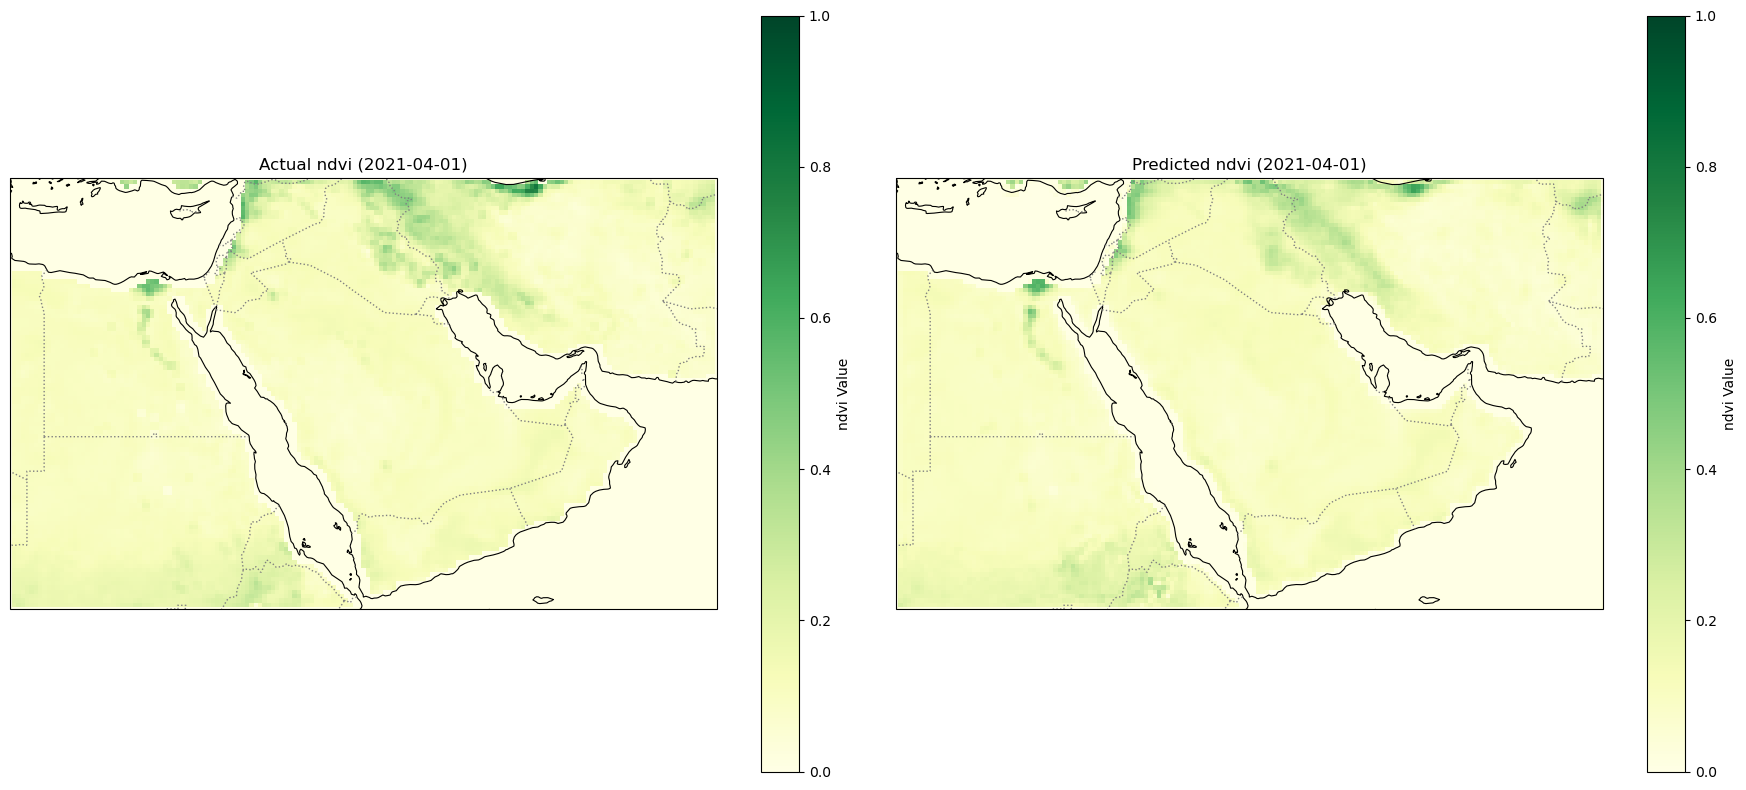

In [20]:
# --- Plotting Heatmaps ---
# We'll plot a few samples from the test set.
num_samples_to_plot = min(3, X_test_final.shape[0]) # Plot up to 3 samples

#for i in range(num_samples_to_plot):
for i in [20]:
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Get the actual timestamp for the current sample
    # The time index for y_test_target[i] corresponds to:
    # (start of test_data_raw) + (start of y sequence relative to its raw data) + (current sample index i)
    # test_data_raw starts at split_index in data_np
    # The y sequence starts at (n_input_timesteps) relative to its raw data (train_data_raw or test_data_raw)
    # So, the absolute time index in data_np for this y_test sample is:
    # split_index + (index of current sample 'i' in X_test_final) + n_input_timesteps
    actual_time_index = split_index + i + n_input_timesteps
    current_timestamp = final_land_dataset_unstacked['time'].values[actual_time_index]
    timestamp_str = pd.to_datetime(str(current_timestamp)).strftime('%Y-%m-%d') # Format for title

    # Plot Actual NDVI
    ax_actual = axes[0]
    # Use pcolormesh for better handling of grid boundaries and NaNs
    im_actual = ax_actual.pcolormesh(lons, lats, y_test_original_scale[i, :, :],
                                     cmap='YlGn', # Greenish colormap for NDVI
                                     transform=ccrs.PlateCarree(),
                                     vmin=0, vmax=1) # NDVI typically ranges from -1 to 1, but often 0 to 1 for vegetation
    ax_actual.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax_actual.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    ax_actual.set_title(f'Actual {target_channel_name} ({timestamp_str})') # Updated title
    plt.colorbar(im_actual, ax=ax_actual, label=f'{target_channel_name} Value')
    ax_actual.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree()) # Set extent to Arabian Peninsula area

    # Plot Predicted NDVI
    ax_pred = axes[1]
    im_pred = ax_pred.pcolormesh(lons, lats, predictions_original_scale[i, :, :],
                                 cmap='YlGn',
                                 transform=ccrs.PlateCarree(),
                                 vmin=0, vmax=1)
    ax_pred.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax_pred.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    ax_pred.set_title(f'Predicted {target_channel_name} ({timestamp_str})') # Updated title
    plt.colorbar(im_pred, ax=ax_pred, label=f'{target_channel_name} Value')
    ax_pred.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree()) # Set extent

    plt.tight_layout()
    plt.show()



--- Visualizing Error Map (Absolute Difference) for NDVI ---


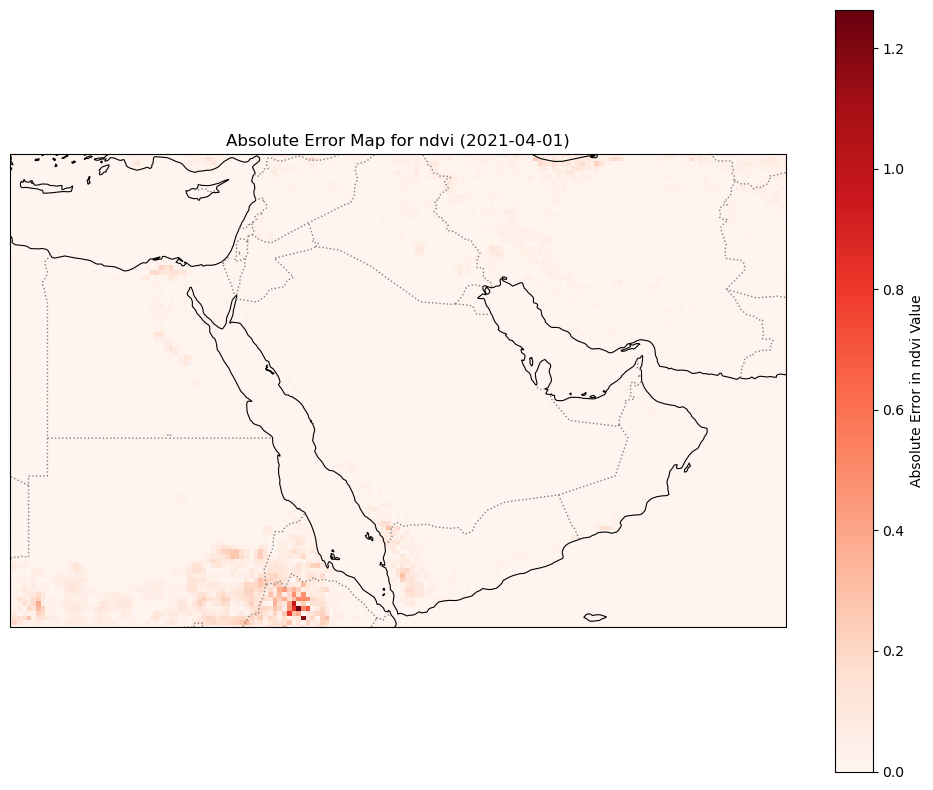

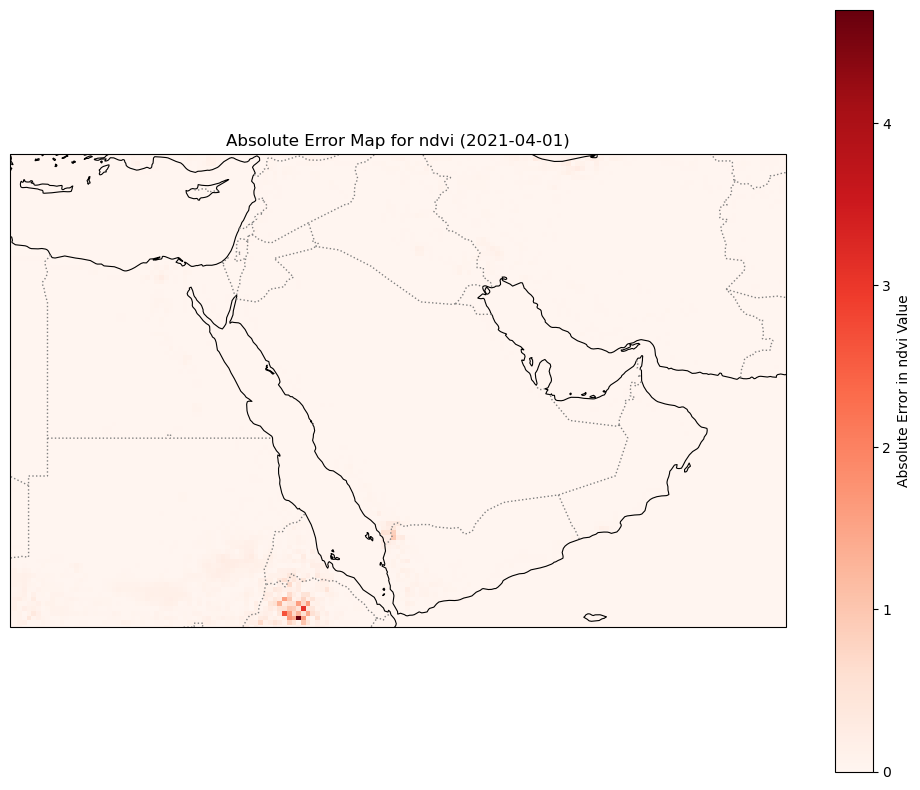

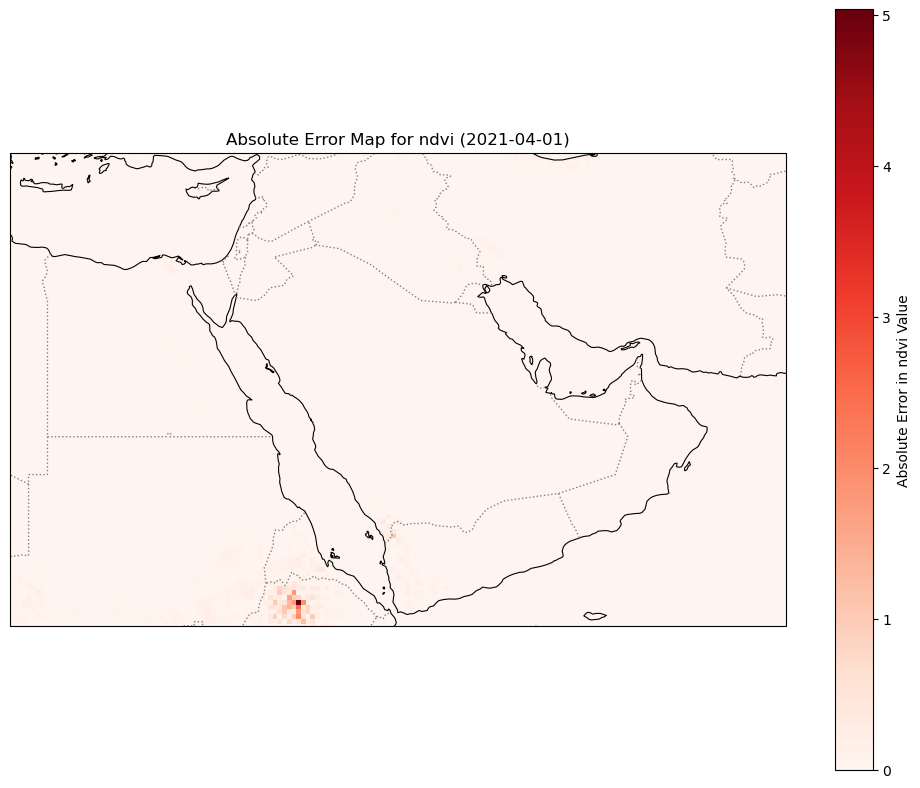


Visualization complete.


In [21]:
# --- NEW: Plot Error Map ---
print("\n--- Visualizing Error Map (Absolute Difference) for NDVI ---")

# Calculate the absolute difference (error)
error_map = np.abs(predictions_original_scale - y_test_original_scale)

for i in range(num_samples_to_plot):
    fig = plt.figure(figsize=(10, 8))
    ax_error = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Plot Error Map
    # Choose a colormap that highlights larger errors (e.g., 'Reds', 'magma', 'hot')
    # Set vmax based on the maximum expected error for better visualization.
    im_error = ax_error.pcolormesh(lons, lats, error_map[i, :, :],
                                   cmap='Reds', # Or 'magma', 'hot_r'
                                   transform=ccrs.PlateCarree(),
                                   vmin=0, vmax=np.max(error_map[i,:,:])) # Dynamic vmax for each sample's error range
                                                                         # Or set a fixed vmax like 0.2 for NDVI error

    ax_error.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax_error.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    ax_error.set_title(f'Absolute Error Map for {target_channel_name} ({timestamp_str})') # Updated title
    plt.colorbar(im_error, ax=ax_error, label=f'Absolute Error in {target_channel_name} Value')
    ax_error.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

print("\nVisualization complete.")
